In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xlrd
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.optimize as spop
# кульбак лейбнер
from scipy.special import kl_div
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
# Импорт openpyxl
import openpyxl
from openpyxl import load_workbook
import random
from scipy.special import rel_entr
from sklearn.metrics import make_scorer, cohen_kappa_score
from sklearn.model_selection import cross_val_score
from scipy.stats import kendalltau
from itertools import combinations
# Для оверсемплинга
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.model_selection import train_test_split

# Загрузка обучающей и валидационной выборки

In [16]:
path_main = r'C:\Users\mikhe\Documents'
path_reports = [r'\РЕЙТИНГ_МЕТОДИКА3_010122_010723.xlsx']

In [17]:
# Забираем колонки только с значениями
x = list(np.linspace(1,143,72))
x.insert(0,0)
x.pop()
x = list(map(int,x))

# Читаем каждую книгу объединяем все листы в один датафрейм
combined = pd.DataFrame()
# Цикл по файлам
for xl_file in path_reports:
    # Загружаем файл Excel
    xl_file_path = path_main + xl_file
    wb = load_workbook(xl_file_path)
    # Цикл по листам
    for sheet_name in wb.sheetnames:
        if sheet_name not in ['Лист1', 'D0001', 'D0002']:
            # Получаем дату отчета из ячейки B2
            ws = wb[sheet_name]
            report_date = ws.cell(row=2, column=2).value
            
#             if isinstance(report_date, datetime):
#             report_date = report_date.strftime('%d.%m.%Y')
            report_date = datetime.strptime(report_date, '"%d.%m.%Y"')
                
            df = pd.read_excel(xl_file_path, sheet_name=sheet_name, skiprows=7, usecols=x)
            df = df.T
            df.columns = df.iloc[0]
            df = df[1:]
            df = df[(df['Наличие рейтинга АКРА'] == 1) | (df['Наличие рейтинга НРА (агентство)'] == 1) | 
                    (df['Наличие рейтинга НКР'] == 1) | (df['Наличие рейтинга Эксперт РА'] == 1)]
            df = df[(df['Структура собственности'] != 0)]
            df = df[(df['Кредиты ЮЛ'] != 0) & (df['Средства клиентов, не являющихся КО'] != 0) & 
                    (df['БИЗНЕС-ПРОФИЛЬ'] > 0)]
            df['report_date'] = report_date
            df = df[['1.1. Отношение кредитов к депозитам (LDR)', '1.2. Доля средств населения', '1.3. Надежность банка',
                     '1.4. Норматив мгновенной ликвидности', '1.5. Норматив текущей ликвидности', 
                     '2.1. Достаточность собственных средств', '2.2. Достаточность основного капитала',
                     '2.3. Устойчивость капитала', '2.4. Доля основного капитала в общем капитале', 
                     '3.1. ROE', '3.2. ROA', '4.1. Коэффициент процентных доходов', 
                     '4.2. Коэффициент процентных расходов', '4.3. Доля операционных расходов в доходах',
                     '5.1. Прирост кредитов', '5.2. Уровень просроченной задолженности', 
                     '5.3. Отношение NPL к Капиталу  (1.2)', '5.4. Коэффициент резервирования', 
                     '5.5. Стоимость риска', 'Доля рынка', 'Стабильность доли рынка',
                     'Отклонение темпов роста', 'Диверсификация дохода', 'География присутствия', 
                     'Структура собственности', 'Доля государства', 'Частные акционеры', 'Качество управления', 
                     'Деловая репутация', 'Связанность операций с бизнесом', 'Отчетность МСФО', 'Рейтинги НРА', 
                     'Количество рейтингов НРА (баллы)', 'Прогноз по рейтингам НРА', 'ПОДДЕРЖКА АКЦИОНЕРОВ', 
                     'ПОДДЕРЖКА ГОСУДАРСТВА', 'Универс рейтинг по вшнешнему', 'report_date']]
            combined = pd.concat([combined, df])

# Переименовываем столбец
combined = combined.rename(columns={'Универс рейтинг по вшнешнему': 'External_rating'})

# Заполняем пропущенные значения
combined.fillna(value=0, inplace=True)

# Удаляем дубликаты
resultDataSet = combined.drop_duplicates()

# Заменяем значения 0.0001 и -0.0001 на 0
resultDataSet.replace(0.0001, 0, inplace=True)
resultDataSet.replace(-0.0001, 0, inplace=True)

# Создаем новый столбец 'ПОДДЕРЖКА МАКСИМУМ' с максимальным значением из 'ПОДДЕРЖКА АКЦИОНЕРОВ' и 'ПОДДЕРЖКА ГОСУДАРСТВА'
resultDataSet['ПОДДЕРЖКА МАКСИМУМ'] = np.maximum(resultDataSet['ПОДДЕРЖКА АКЦИОНЕРОВ'], resultDataSet['ПОДДЕРЖКА ГОСУДАРСТВА'])
# Удаляем столбцы 'ПОДДЕРЖКА АКЦИОНЕРОВ' и 'ПОДДЕРЖКА ГОСУДАРСТВА'
resultDataSet.drop(['ПОДДЕРЖКА АКЦИОНЕРОВ', 'ПОДДЕРЖКА ГОСУДАРСТВА'], axis=1, inplace=True)

# Выводим уникальные значения в столбце 'External_rating'
print(set(resultDataSet['External_rating']))

{7, 8, 9, 10, 11, 12, 13, 14}


C:\Users\mikhe\AppData\Local\Temp\ipykernel_18788\2618003070.py:61: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  resultDataSet.replace(0.0001, 0, inplace=True)


In [18]:
main_rD = resultDataSet.copy(deep=True)

In [45]:
path_main = r'C:\Users\mikhe\Documents\Валидационная выборка'
path_reports = [r'\РЕЙТИНГ_МЕТОДИКА3_тестовая база_010924.xlsx']
# path_reports = [r'\РЕЙТИНГ_МЕТОДИКА__ДО03.xlsx']

In [100]:
# Функция для определения индекса последнего непустого столбца
def get_last_valid_column(ws):
    for col_idx in range(1, ws.max_column + 1):
        if all([ws.cell(row=row_idx, column=col_idx).value is None for row_idx in range(1, ws.max_row + 1)]):
            return col_idx - 1  # Возвращаем индекс последнего непустого столбца
    return ws.max_column  # Если все столбцы заполнены, возвращаем максимальный


In [46]:
# Забираем колонки только с значениями
x = list(np.linspace(1,143,72))
x.insert(0,0)
x.pop()
x = list(map(int,x))

# Читаем каждую книгу объединяем все листы в один датафрейм
combined = pd.DataFrame()
# Цикл по файлам
for xl_file in path_reports:
    # Загружаем файл Excel
    xl_file_path = path_main + xl_file
    wb = load_workbook(xl_file_path)
    # Цикл по листам
    for sheet_name in wb.sheetnames:
        if sheet_name not in ['Лист1']:
            # Получаем дату отчета из ячейки B2
            ws = wb[sheet_name]
            report_date = ws.cell(row=2, column=2).value
            
#             if isinstance(report_date, datetime):
#             report_date = report_date.strftime('%d.%m.%Y')
            report_date = datetime.strptime(report_date, '"%d.%m.%Y"')
                
            df = pd.read_excel(xl_file_path, sheet_name=sheet_name, skiprows=7, usecols=x)
            df = df.T
            df.columns = df.iloc[0]
            df = df[1:]
            df = df[(df['Наличие рейтинга АКРА'] == 1) | (df['Наличие рейтинга НРА (агентство)'] == 1) | 
                    (df['Наличие рейтинга НКР'] == 1) | (df['Наличие рейтинга Эксперт РА'] == 1)]
            df = df[(df['Структура собственности'] != 0)]
            df = df[(df['Кредиты ЮЛ'] != 0) & (df['Средства клиентов, не являющихся КО'] != 0) & 
                    (df['БИЗНЕС-ПРОФИЛЬ'] > 0)]
            df['report_date'] = report_date
            df = df[['1.1. Отношение кредитов к депозитам (LDR)', '1.2. Доля средств населения', '1.3. Надежность банка',
                     '1.4. Норматив мгновенной ликвидности', '1.5. Норматив текущей ликвидности', 
                     '2.1. Достаточность собственных средств', '2.2. Достаточность основного капитала',
                     '2.3. Устойчивость капитала', '2.4. Доля основного капитала в общем капитале', 
                     '3.1. ROE', '3.2. ROA', '4.1. Коэффициент процентных доходов', 
                     '4.2. Коэффициент процентных расходов', '4.3. Доля операционных расходов в доходах',
                     '5.1. Прирост кредитов', '5.2. Уровень просроченной задолженности', 
                     '5.3. Отношение NPL к Капиталу  (1.2)', '5.4. Коэффициент резервирования', 
                     '5.5. Стоимость риска', 'Доля рынка', 'Стабильность доли рынка',
                     'Отклонение темпов роста', 'Диверсификация дохода', 'География присутствия', 
                     'Структура собственности', 'Доля государства', 'Частные акционеры', 'Качество управления', 
                     'Деловая репутация', 'Связанность операций с бизнесом', 'Отчетность МСФО', 'Рейтинги НРА', 
                     'Количество рейтингов НРА (баллы)', 'Прогноз по рейтингам НРА', 'ПОДДЕРЖКА АКЦИОНЕРОВ', 
                     'ПОДДЕРЖКА ГОСУДАРСТВА', 'Универс рейтинг по вшнешнему', 'report_date']]
            combined = pd.concat([combined, df])

# Переименовываем столбец
combined = combined.rename(columns={'Универс рейтинг по вшнешнему': 'External_rating'})

# Заполняем пропущенные значения
combined.fillna(value=0, inplace=True)

# Удаляем дубликаты
resultDataSet = combined.drop_duplicates()

# Заменяем значения 0.0001 и -0.0001 на 0
resultDataSet.replace(0.0001, 0, inplace=True)
resultDataSet.replace(-0.0001, 0, inplace=True)

# Создаем новый столбец 'ПОДДЕРЖКА МАКСИМУМ' с максимальным значением из 'ПОДДЕРЖКА АКЦИОНЕРОВ' и 'ПОДДЕРЖКА ГОСУДАРСТВА'
resultDataSet['ПОДДЕРЖКА МАКСИМУМ'] = np.maximum(resultDataSet['ПОДДЕРЖКА АКЦИОНЕРОВ'], resultDataSet['ПОДДЕРЖКА ГОСУДАРСТВА'])
# Удаляем столбцы 'ПОДДЕРЖКА АКЦИОНЕРОВ' и 'ПОДДЕРЖКА ГОСУДАРСТВА'
resultDataSet.drop(['ПОДДЕРЖКА АКЦИОНЕРОВ', 'ПОДДЕРЖКА ГОСУДАРСТВА'], axis=1, inplace=True)

# Выводим уникальные значения в столбце 'External_rating'
print(set(resultDataSet['External_rating']))

{7, 8, 9, 10, 11, 12, 13, 14}


C:\Users\mikhe\AppData\Local\Temp\ipykernel_18788\2800017139.py:61: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  resultDataSet.replace(0.0001, 0, inplace=True)


In [109]:
# Читаем каждую книгу и объединяем все листы в один датафрейм
combined = pd.DataFrame()

# Цикл по файлам
for xl_file in path_reports:
    # Загружаем файл Excel
    xl_file_path = path_main + xl_file
    wb = load_workbook(xl_file_path)
    
    # Цикл по листам
    for sheet_name in wb.sheetnames:
        if sheet_name not in ['Лист1']:
            # Получаем дату отчета из ячейки B2
            ws = wb[sheet_name]
            report_date = ws.cell(row=2, column=2).value
            
            # Преобразуем дату отчета, если она существует
            if report_date is not None and isinstance(report_date, str):
                report_date = datetime.strptime(report_date, '"%d.%m.%Y"')
            
            # Загружаем весь лист в DataFrame
            df = pd.read_excel(xl_file_path, sheet_name=sheet_name, skiprows=7)
            
            # Удаляем все пустые столбцы
            df = df.dropna(axis=1, how='all')

            # Транспонируем DataFrame и переопределяем колонки
            df = df.T
            df.columns = df.iloc[0]
            df = df[1:]

            # # Применяем фильтры
            # df = df[(df['Наличие рейтинга АКРА'] == 1) | (df['Наличие рейтинга НРА (агентство)'] == 1) | 
            #         (df['Наличие рейтинга НКР'] == 1) | (df['Наличие рейтинга Эксперт РА'] == 1)]
            # df = df[(df['Структура собственности'] != 0)]
            df = df[(df['БИЗНЕС-ПРОФИЛЬ'] > 0)]
            
            # Добавляем дату отчета
            df['report_date'] = report_date

            # Оставляем только нужные столбцы (если они присутствуют)
            columns_needed = ['1.1. Отношение кредитов к депозитам (LDR)', '1.2. Доля средств населения', '1.3. Надежность банка',
                              '1.4. Норматив мгновенной ликвидности', '1.5. Норматив текущей ликвидности', 
                              '2.1. Достаточность собственных средств', '2.2. Достаточность основного капитала',
                              '2.3. Устойчивость капитала', '2.4. Доля основного капитала в общем капитале', 
                              '3.1. ROE', '3.2. ROA', '4.1. Коэффициент процентных доходов', 
                              '4.2. Коэффициент процентных расходов', '4.3. Доля операционных расходов в доходах',
                              '5.1. Прирост кредитов', '5.2. Уровень просроченной задолженности', 
                              '5.3. Отношение NPL к Капиталу  (1.2)', '5.4. Коэффициент резервирования', 
                              '5.5. Стоимость риска', 'Доля рынка', 'Стабильность доли рынка',
                              'Отклонение темпов роста', 'Диверсификация дохода', 'География присутствия', 
                              'Структура собственности', 'Доля государства', 'Частные акционеры', 'Качество управления', 
                              'Деловая репутация', 'Связанность операций с бизнесом', 'Отчетность МСФО', 'Рейтинги НРА', 
                              'Количество рейтингов НРА (баллы)', 'Прогноз по рейтингам НРА', 'ПОДДЕРЖКА АКЦИОНЕРОВ', 
                              'ПОДДЕРЖКА ГОСУДАРСТВА', 'Универс рейтинг по вшнешнему', 'report_date']
            
            # Проверяем наличие нужных столбцов и отбираем их
            df = df[[col for col in columns_needed if col in df.columns]]
            
            # Добавляем данные в общий DataFrame
            combined = pd.concat([combined, df])

# Переименовываем столбец
combined = combined.rename(columns={'Универс рейтинг по вшнешнему': 'External_rating'})

# Заполняем пропущенные значения
combined.fillna(value=0, inplace=True)

# Удаляем дубликаты
resultDataSet = combined.drop_duplicates()

# Заменяем значения 0.0001 и -0.0001 на 0
resultDataSet.replace(0.0001, 0, inplace=True)
resultDataSet.replace(-0.0001, 0, inplace=True)

# Создаем новый столбец 'ПОДДЕРЖКА МАКСИМУМ' с максимальным значением из 'ПОДДЕРЖКА АКЦИОНЕРОВ' и 'ПОДДЕРЖКА ГОСУДАРСТВА'
resultDataSet['ПОДДЕРЖКА МАКСИМУМ'] = np.maximum(resultDataSet['ПОДДЕРЖКА АКЦИОНЕРОВ'], resultDataSet['ПОДДЕРЖКА ГОСУДАРСТВА'])

# Удаляем столбцы 'ПОДДЕРЖКА АКЦИОНЕРОВ' и 'ПОДДЕРЖКА ГОСУДАРСТВА'
resultDataSet.drop(['ПОДДЕРЖКА АКЦИОНЕРОВ', 'ПОДДЕРЖКА ГОСУДАРСТВА'], axis=1, inplace=True)

# Выводим уникальные значения в столбце 'External_rating'
print(set(resultDataSet['External_rating']))

{1, 7, 8, 9, 10, 11, 12, 13, 14}


C:\Users\mikhe\AppData\Local\Temp\ipykernel_18788\3961396594.py:73: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  resultDataSet.replace(0.0001, 0, inplace=True)


In [110]:
test_rD = resultDataSet.copy(deep=True)

In [111]:
test_rD.sort_values(by='report_date')

Наименование показателя,1.1. Отношение кредитов к депозитам (LDR),1.2. Доля средств населения,1.3. Надежность банка,1.4. Норматив мгновенной ликвидности,1.5. Норматив текущей ликвидности,2.1. Достаточность собственных средств,2.2. Достаточность основного капитала,2.3. Устойчивость капитала,2.4. Доля основного капитала в общем капитале,3.1. ROE,...,Качество управления,Деловая репутация,Связанность операций с бизнесом,Отчетность МСФО,Рейтинги НРА,Количество рейтингов НРА (баллы),Прогноз по рейтингам НРА,External_rating,report_date,ПОДДЕРЖКА МАКСИМУМ
"""СДМ-Банк"" (ПАО)",37.043903,59.793852,183.390686,52.410,97.527,13.142891,11.902973,63.773051,90.565867,14.681443,...,0.0,0.0,0,0,0.0,0.0,0.0,1,2024-09-01,0
"ООО ""Экспобанк""",82.979864,35.374366,80.265692,37.323,73.052,11.527201,10.920462,-114.957961,94.736461,5.305857,...,1.5,1.0,0,0,5.0,1.2,1.2,11,2024-09-01,10
"ООО ""ФФИН Банк""",6.988926,48.531832,228.122567,58.502,92.402,20.644252,12.473504,121.192714,60.421193,49.333317,...,1.5,1.0,1,0,0.0,0.0,0.0,1,2024-09-01,0
"ООО ""Промсельхозбанк""",0.048476,93.418648,0.000000,0.000,120.117,9.539981,0.000000,202.609443,0.000000,49.256734,...,0.0,1.0,0,1,0.0,1.0,0.0,7,2024-09-01,0
"ООО ""Примтеркомбанк""",95.147790,9.035504,125.681767,0.000,108.565,23.792909,15.386811,437.779386,64.669732,60.213039,...,0.0,0.0,0,0,0.0,0.0,0.0,1,2024-09-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"АО ""РН Банк""",190.045646,4.047704,0.000000,164.792,133.640,30.175871,0.000000,390.512634,0.000000,11.802822,...,1.5,1.0,1,4,0.0,1.0,0.0,14,2024-09-01,16
"АО ""Райффайзенбанк""",33.075289,28.991066,195.935098,205.300,392.650,31.412649,25.909443,194.644468,82.480923,29.037764,...,0.0,2.0,0,0,5.0,1.2,1.2,14,2024-09-01,10
"АО ""ПЕРВОУРАЛЬСКБАНК""",49.170211,47.439265,101.726390,0.000,89.668,10.767702,8.428572,74.829117,78.276427,36.932889,...,0.0,0.0,0,0,0.0,0.0,0.0,1,2024-09-01,0
"АО АКБ ""ЕВРОФИНАНС МОСНАРБАНК""",85.311857,27.129834,83.678749,46.777,128.091,20.462628,17.811884,-130.751514,87.045923,14.020551,...,0.0,0.0,0,0,0.0,0.0,0.0,1,2024-09-01,0


In [112]:
main_rD['flag'] = 'main'
test_rD['flag'] = 'test'
gen_rD = pd.concat([main_rD, test_rD])

In [113]:
resultDataSet = gen_rD.copy(deep=True)

In [152]:
resultDataSet

Наименование показателя,1.1. Отношение кредитов к депозитам (LDR),1.2. Доля средств населения,1.3. Надежность банка,1.4. Норматив мгновенной ликвидности,1.5. Норматив текущей ликвидности,2.1. Достаточность собственных средств,2.2. Достаточность основного капитала,2.3. Устойчивость капитала,2.4. Доля основного капитала в общем капитале,3.1. ROE,...,Деловая репутация,Связанность операций с бизнесом,Отчетность МСФО,Рейтинги НРА,Количество рейтингов НРА (баллы),Прогноз по рейтингам НРА,External_rating,report_date,ПОДДЕРЖКА МАКСИМУМ,flag
"""Азиатско-Тихоокеанский Банк"" (ПАО)",73.071787,54.263972,100.596731,70.669,89.429,11.112204,9.622349,41.154473,86.592626,27.723306,...,1.0,0,0.0,4.0,1.2,1.2,10,2023-07-01,8,main
"""Банк ""МБА-МОСКВА"" ООО",39.186875,13.775450,127.308044,32.910,77.383,37.799842,34.695858,568.804787,91.788368,4.957761,...,1.0,1,0.0,4.0,1.0,1.2,9,2023-07-01,0,main
Азия-Инвест Банк (АО),21.371008,0.224621,84.555873,44.105,85.600,12.381090,8.113560,266.868437,65.531868,63.178405,...,1.0,0,0.0,4.0,1.0,1.2,10,2023-07-01,10,main
"АКБ ""Абсолют Банк"" (ПАО)",75.960517,50.109096,97.042698,45.112,62.325,8.804724,7.461439,38.512612,84.743593,17.251135,...,1.0,1,4.0,5.0,1.0,1.2,11,2023-07-01,0,main
"АКБ ""Держава"" ПАО",51.810933,7.098363,176.957224,80.919,148.269,7.477770,6.356109,75.528442,85.000057,67.802596,...,1.0,0,0.0,4.0,1.2,1.2,9,2023-07-01,0,main
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ПАО РОСБАНК,102.651209,36.469190,59.501165,41.679,68.607,9.474488,8.489654,62.561791,89.605407,23.759305,...,2.0,1,0.0,5.0,1.2,1.2,14,2024-09-01,20,test
ПАО Сбербанк,102.383059,52.184584,0.000000,47.964,86.278,9.337386,8.534560,60.572656,91.402029,25.046579,...,2.0,0,1.0,5.0,1.0,1.2,14,2024-09-01,20,test
"ПАО СКБ Приморья ""Примсоцбанк""",81.880479,51.437555,121.340698,73.799,166.422,10.234853,8.735130,113.074259,85.346902,26.132031,...,0.0,0,0.0,5.0,1.0,1.2,11,2024-09-01,0,test
РНКО ЕАРК (АО),0.000000,0.000000,0.000000,0.000,0.000,5.926418,0.000000,-1.352541,0.000000,-7.539797,...,0.0,0,0.0,0.0,0.0,0.0,1,2024-09-01,0,test


## Разделение на трейн и тест

In [153]:
resultDataSet_train = resultDataSet[(resultDataSet['report_date'] >= '2022-03-01') & (resultDataSet['report_date'] <= '2023-07-01')]
resultDataSet_train = resultDataSet_train.sort_values(by='report_date')

resultDataSet_test = resultDataSet[(resultDataSet['report_date'] >= '2023-08-01')]
resultDataSet_test = resultDataSet_test.sort_values(by='report_date')

In [116]:
# Удаляем Сбер и ВТБ из трейн
resultDataSet_train = resultDataSet_train.drop(['ПАО Сбербанк', 'Банк ВТБ (ПАО)'])

# Оверсемплинг

In [117]:
resultDataSet_train['External_rating'].value_counts()

External_rating
11    165
9     149
13    141
10    104
8      74
7      66
14     49
12     45
Name: count, dtype: int64

In [118]:
## Делаем оверсемплинг только трейн данных
# Определение категориальных признаков (дискретных)
discrete_cols = ['Доля рынка', 'Стабильность доли рынка', 'Отклонение темпов роста',
                 'Диверсификация дохода', 'География присутствия', 'Структура собственности', 
                 'Доля государства', 'Частные акционеры', 'Качество управления', 'Деловая репутация', 
                 'Связанность операций с бизнесом', 'Отчетность МСФО', 'Рейтинги НРА', 
                 'Количество рейтингов НРА (баллы)', 'Прогноз по рейтингам НРА', 'ПОДДЕРЖКА МАКСИМУМ']

# Определение непрерывных признаков
continuous_cols = list(resultDataSet_train.columns[:19])

# Разделение признаков (X) и целевой переменной (y)
X = resultDataSet_train[continuous_cols + discrete_cols]
y = resultDataSet_train['External_rating']

# Определение индексов категориальных признаков для SMOTENC
categorical_feature_indices = [X.columns.get_loc(col) for col in discrete_cols]

# Применение SMOTENC для оверсемплинга как непрерывных, так и категориальных признаков
smotenc = SMOTENC(categorical_features=categorical_feature_indices, random_state=42)
X_resampled_train, y_resampled_train = smotenc.fit_resample(X, y)


In [119]:
y_resampled_train.value_counts()

External_rating
8     165
9     165
7     165
13    165
14    165
12    165
10    165
11    165
Name: count, dtype: int64

In [120]:
# Собираем train
resultDataSet_train = X_resampled_train
resultDataSet_train['External_rating'] = y_resampled_train

# Сейчас будем разделять столбцы

In [121]:
# нам необходимо прописать какие в принципе могут быть категории у каждой колонки

resultDataSet_train['Доля рынка'] = pd.Categorical(resultDataSet_train['Доля рынка'], categories=[0, 0.5, 1, 2, 3, 4, 5])
resultDataSet_train['Стабильность доли рынка'] = pd.Categorical(resultDataSet_train['Стабильность доли рынка'], categories=[0, 0.5, 1, 1.2, 1.5, 1.8, 2])
resultDataSet_train['Отклонение темпов роста'] = pd.Categorical(resultDataSet_train['Отклонение темпов роста'], categories=[0,0.5,1,1.5,2,2.5,3])
resultDataSet_train['Диверсификация дохода'] = pd.Categorical(resultDataSet_train['Диверсификация дохода'], categories=[0,0.6,1.2,1.8,2.4,3])
resultDataSet_train['География присутствия'] = pd.Categorical(resultDataSet_train['География присутствия'], categories=[0,1,2,3,4])
resultDataSet_train['Структура собственности'] = pd.Categorical(resultDataSet_train['Структура собственности'], categories=[-1,1,2])
resultDataSet_train['Доля государства'] = pd.Categorical(resultDataSet_train['Доля государства'], categories=[0,1,2,3,4,5])
resultDataSet_train['Частные акционеры'] = pd.Categorical(resultDataSet_train['Частные акционеры'], categories=[0,1,2,3])
resultDataSet_train['Качество управления'] = pd.Categorical(resultDataSet_train['Качество управления'], categories=[-3,-1.5,0,1.5,3])
resultDataSet_train['Деловая репутация'] = pd.Categorical(resultDataSet_train['Деловая репутация'], categories=[-1,0,1,2])
resultDataSet_train['Связанность операций с бизнесом'] = pd.Categorical(resultDataSet_train['Связанность операций с бизнесом'], categories=[0,1,2])
resultDataSet_train['Отчетность МСФО'] = pd.Categorical(resultDataSet_train['Отчетность МСФО'], categories=[0,1,2,3,4])
resultDataSet_train['Рейтинги НРА'] = pd.Categorical(resultDataSet_train['Рейтинги НРА'], categories=[0,2.5,4,5])
resultDataSet_train['Количество рейтингов НРА (баллы)'] = pd.Categorical(resultDataSet_train['Количество рейтингов НРА (баллы)'], categories=[1,1.2,2])
resultDataSet_train['Прогноз по рейтингам НРА'] = pd.Categorical(resultDataSet_train['Прогноз по рейтингам НРА'], categories=[0,1.2,2])
resultDataSet_train['ПОДДЕРЖКА МАКСИМУМ'] = pd.Categorical(resultDataSet_train['ПОДДЕРЖКА МАКСИМУМ'], categories=[0,8,10,16,20])

resultDataSet_test['Доля рынка'] = pd.Categorical(resultDataSet_test['Доля рынка'], categories=[0, 0.5, 1, 2, 3, 4, 5])
resultDataSet_test['Стабильность доли рынка'] = pd.Categorical(resultDataSet_test['Стабильность доли рынка'], categories=[0, 0.5, 1, 1.2, 1.5, 1.8, 2])
resultDataSet_test['Отклонение темпов роста'] = pd.Categorical(resultDataSet_test['Отклонение темпов роста'], categories=[0,0.5,1,1.5,2,2.5,3])
resultDataSet_test['Диверсификация дохода'] = pd.Categorical(resultDataSet_test['Диверсификация дохода'], categories=[0,0.6,1.2,1.8,2.4,3])
resultDataSet_test['География присутствия'] = pd.Categorical(resultDataSet_test['География присутствия'], categories=[0,1,2,3,4])
resultDataSet_test['Структура собственности'] = pd.Categorical(resultDataSet_test['Структура собственности'], categories=[-1,1,2])
resultDataSet_test['Доля государства'] = pd.Categorical(resultDataSet_test['Доля государства'], categories=[0,1,2,3,4,5])
resultDataSet_test['Частные акционеры'] = pd.Categorical(resultDataSet_test['Частные акционеры'], categories=[0,1,2,3])
resultDataSet_test['Качество управления'] = pd.Categorical(resultDataSet_test['Качество управления'], categories=[-3,-1.5,0,1.5,3])
resultDataSet_test['Деловая репутация'] = pd.Categorical(resultDataSet_test['Деловая репутация'], categories=[-1,0,1,2])
resultDataSet_test['Связанность операций с бизнесом'] = pd.Categorical(resultDataSet_test['Связанность операций с бизнесом'], categories=[0,1,2])
resultDataSet_test['Отчетность МСФО'] = pd.Categorical(resultDataSet_test['Отчетность МСФО'], categories=[0,1,2,3,4])
resultDataSet_test['Рейтинги НРА'] = pd.Categorical(resultDataSet_test['Рейтинги НРА'], categories=[0,2.5,4,5])
resultDataSet_test['Количество рейтингов НРА (баллы)'] = pd.Categorical(resultDataSet_test['Количество рейтингов НРА (баллы)'], categories=[1,1.2,2])
resultDataSet_test['Прогноз по рейтингам НРА'] = pd.Categorical(resultDataSet_test['Прогноз по рейтингам НРА'], categories=[0,1.2,2])
resultDataSet_test['ПОДДЕРЖКА МАКСИМУМ'] = pd.Categorical(resultDataSet_test['ПОДДЕРЖКА МАКСИМУМ'], categories=[0,8,10,16,20])

df_category_train = pd.get_dummies(resultDataSet_train, columns=['Доля рынка', 'Стабильность доли рынка', 'Отклонение темпов роста',
                                                     'Диверсификация дохода', 'География присутствия',
                                                     'Структура собственности', 'Доля государства', 'Частные акционеры', 'Качество управления', 'Деловая репутация', 'Связанность операций с бизнесом', 
                                                     'Отчетность МСФО', 
                                                     'Рейтинги НРА', 'Количество рейтингов НРА (баллы)', 'Прогноз по рейтингам НРА', 
                                                     'ПОДДЕРЖКА МАКСИМУМ'], dtype=int)

df_category_test = pd.get_dummies(resultDataSet_test, columns=['Доля рынка', 'Стабильность доли рынка', 'Отклонение темпов роста',
                                                     'Диверсификация дохода', 'География присутствия',
                                                     'Структура собственности', 'Доля государства', 'Частные акционеры', 'Качество управления', 'Деловая репутация', 'Связанность операций с бизнесом', 
                                                     'Отчетность МСФО', 
                                                     'Рейтинги НРА', 'Количество рейтингов НРА (баллы)', 'Прогноз по рейтингам НРА', 
                                                     'ПОДДЕРЖКА МАКСИМУМ'], dtype=int)

In [171]:
df_category_test.index.get_loc("Банк ВТБ (ПАО)")

30

## Разделяем на категории

In [160]:
# # Переводим external rating в бальный рейтинг
# replacement_dict = {
#     7: 40,
#     8: 50,
#     9: 56,
#     10: 64,
#     11: 74,
#     12: 85,
#     13: 92,
#     14: 97
# }
# df_category['External_rating'] = df_category['External_rating'].replace(replacement_dict)
y_train = df_category_train['External_rating'].values.reshape(-1, 1)
df_cat_drop_train = df_category_train.drop("External_rating", axis = 1)

y_test = df_category_test['External_rating'].values.reshape(-1, 1)
df_cat_drop_test = df_category_test.drop("External_rating", axis = 1) 
df_cat_drop_test = df_cat_drop_test.drop("report_date", axis = 1) 
df_cat_drop_test = df_cat_drop_test.drop("flag", axis=1)

In [123]:
# intervals = [(-np.inf, 45), (45, 53), (53, 60), (60, 68), (68, 80), (80, 90), (90, 95), (95, np.inf)]

# # функция перевода бального рейта в категории
# def score_cat(x):
#     x_category = np.empty(len(x))
#     x_category = x_category.reshape(-1, 1)
#     for index, row in enumerate(x):
#         for i, interval in enumerate(intervals, start = 1):
#             if interval[0] <= row <= interval[1]:
#                 # к номеру интервала прибаляется 6
#                 x_category[index] = i + 6
#                 break
#     return x_category

In [124]:
# # переводим в numpy df_cat_drop, External_rating
# external_numpy = df_category['External_rating'].values.reshape(-1, 1)
# date_numpy = df_category['report_date'].values.reshape(-1, 1)

In [125]:
## Обучающие с 03.22 по 07.23, Тестовые с 08.23
# df_category_train = df_category[(df_category['report_date'] >= '2022-03-01') & (df_category['report_date'] <= '2023-07-01')]
# df_category_train = df_category_train.sort_values(by='report_date')
# external_train = df_category_train['External_rating'].values.reshape(-1, 1)

# df_category_test = df_category[(df_category['report_date'] >= '2023-08-01')]
# df_category_test = df_category_test.sort_values(by='report_date')
# external_test = df_category_test['External_rating'].values.reshape(-1, 1)

In [126]:
# df_category_sorted = df_category.sort_values(by='report_date')

In [127]:
# df_cat_drop_train = df_category_train.drop("External_rating", axis = 1) 
# df_cat_drop_train = df_cat_drop_train.drop("report_date", axis = 1) 
# df_cat_drop_train = df_cat_drop_train.drop("flag", axis=1)

# df_cat_drop_test = df_category_test.drop("External_rating", axis = 1) 
# df_cat_drop_test = df_cat_drop_test.drop("report_date", axis = 1) 
# df_cat_drop_test = df_cat_drop_test.drop("flag", axis=1)

In [128]:
df_train = df_cat_drop_train.values
df_test = df_cat_drop_test.values

### Теперь у нас есть матрица признаков (df_train/df_test), целевая функция (external_numpy)

1.1. Отношение кредитов к депозитам (LDR)


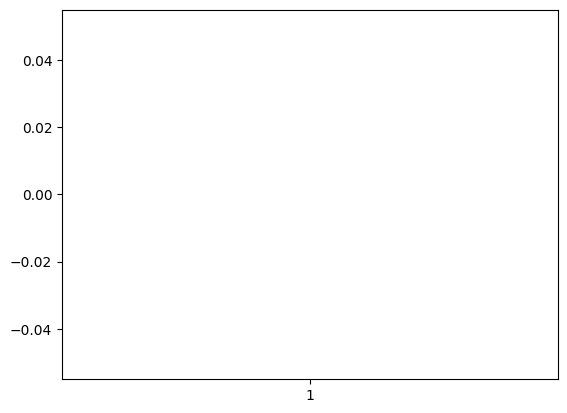

1.2. Доля средств населения


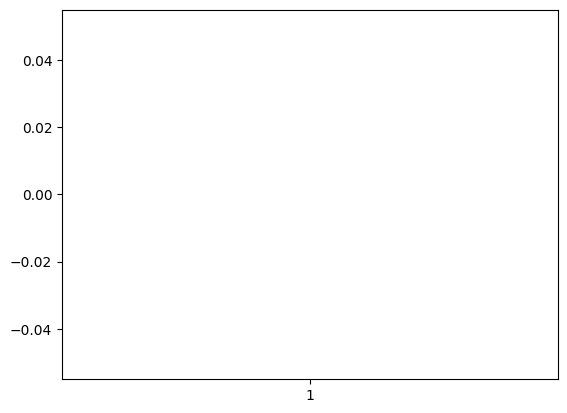

1.3. Надежность банка


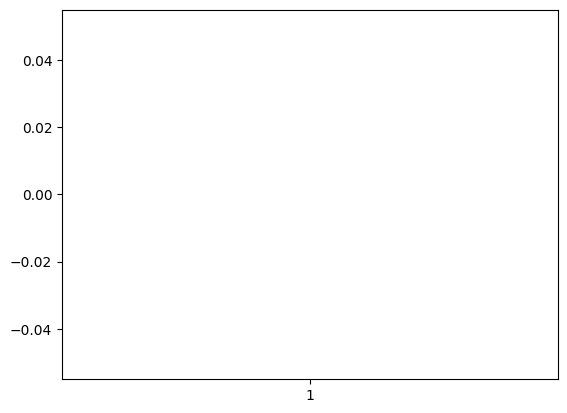

1.4. Норматив мгновенной ликвидности


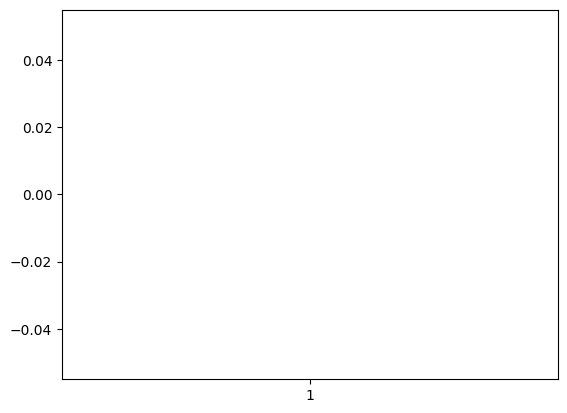

1.5. Норматив текущей ликвидности


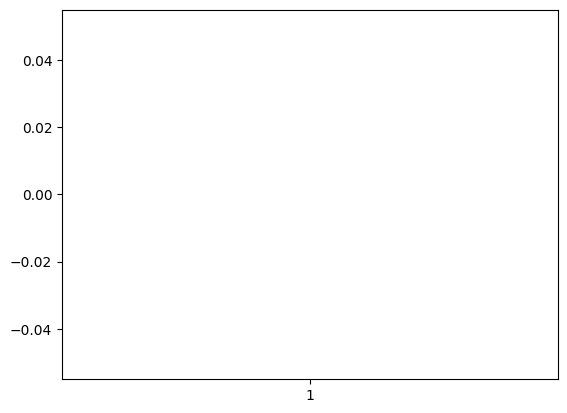

2.1. Достаточность собственных средств


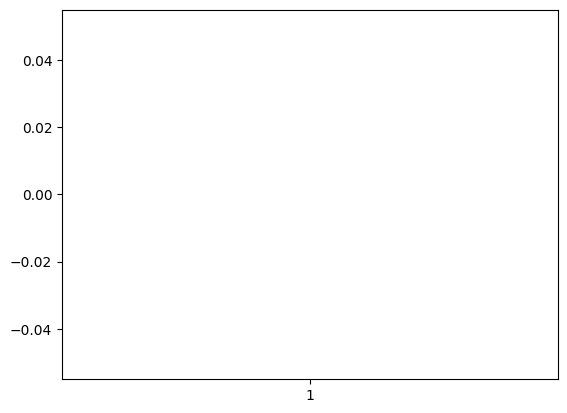

2.2. Достаточность основного капитала


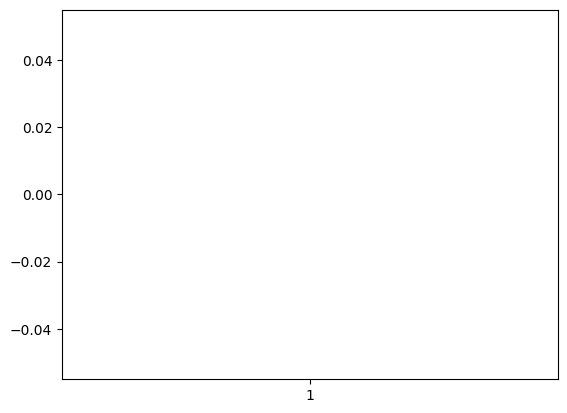

2.3. Устойчивость капитала


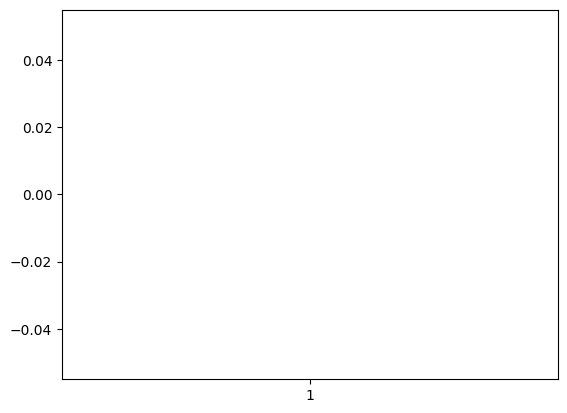

2.4. Доля основного капитала в общем капитале


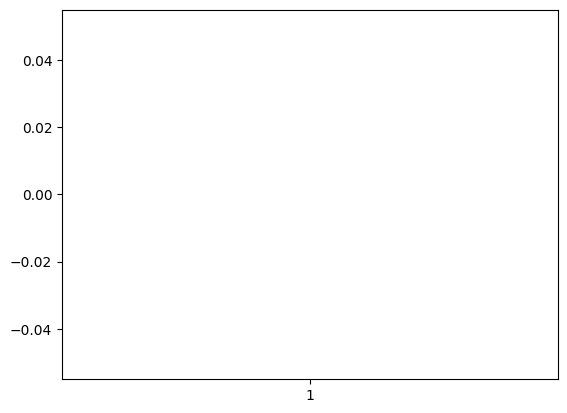

3.1. ROE


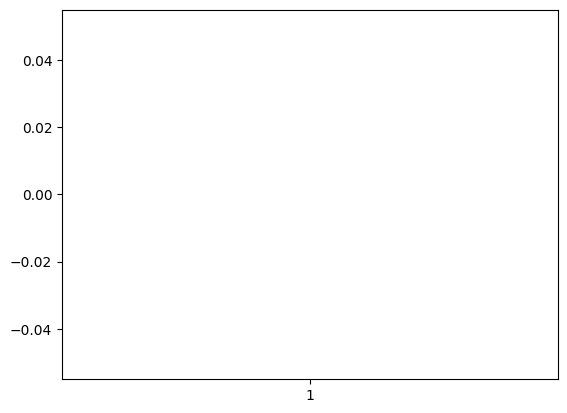

3.2. ROA


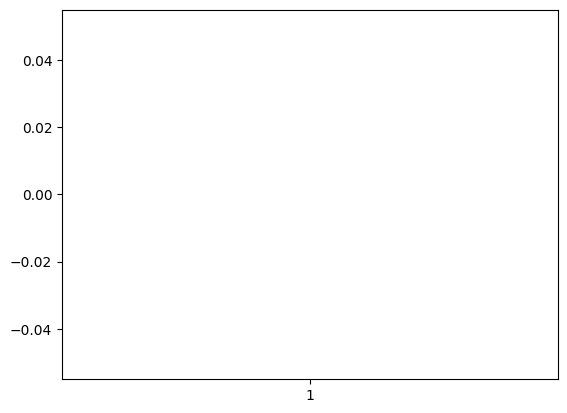

4.1. Коэффициент процентных доходов


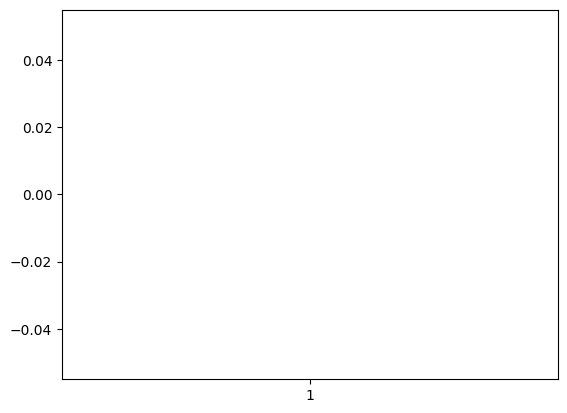

4.2. Коэффициент процентных расходов


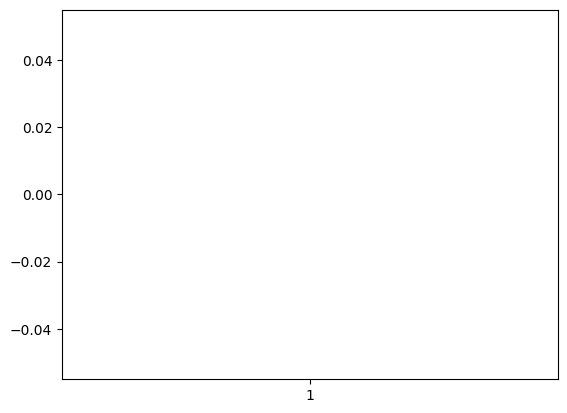

4.3. Доля операционных расходов в доходах


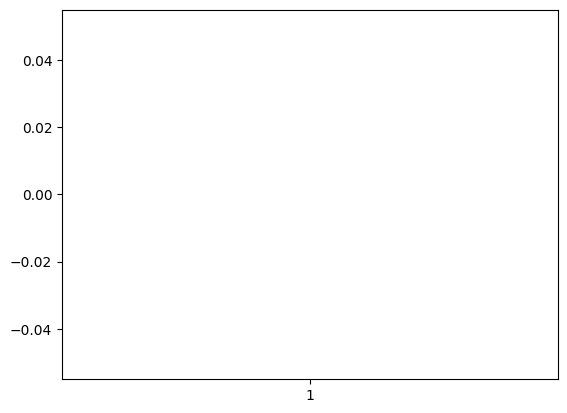

5.1. Прирост кредитов


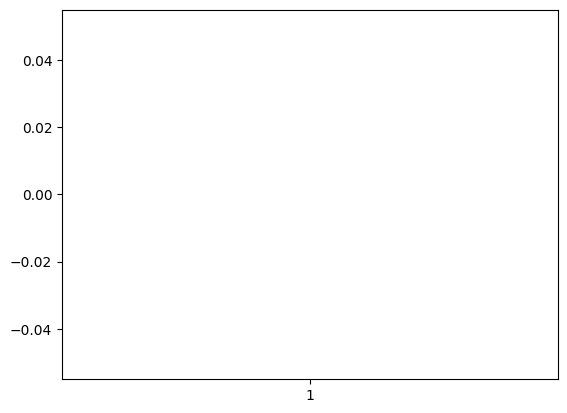

5.2. Уровень просроченной задолженности


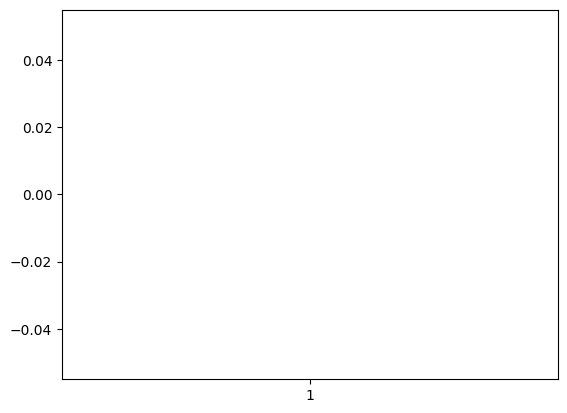

5.3. Отношение NPL к Капиталу  (1.2)


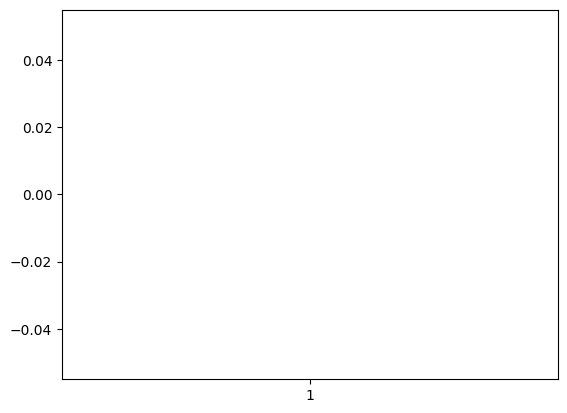

5.4. Коэффициент резервирования


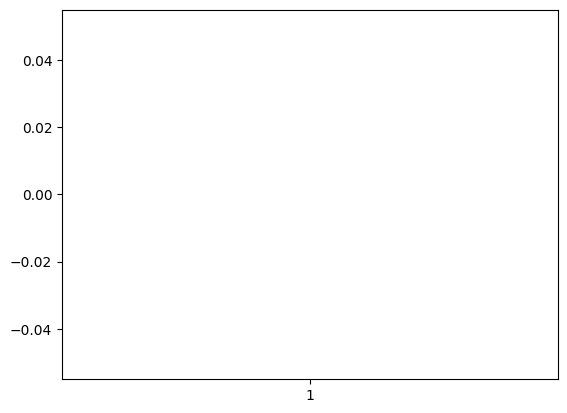

5.5. Стоимость риска


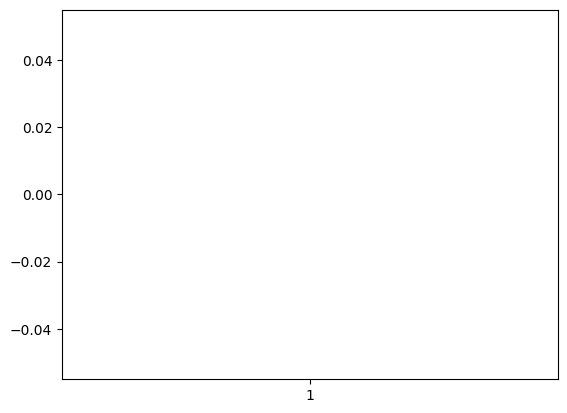

Доля рынка_0.0


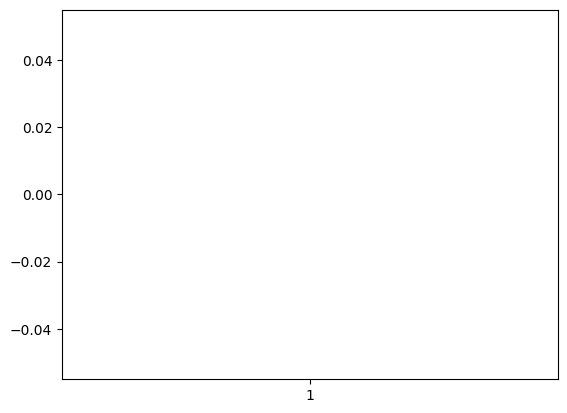

Доля рынка_0.5


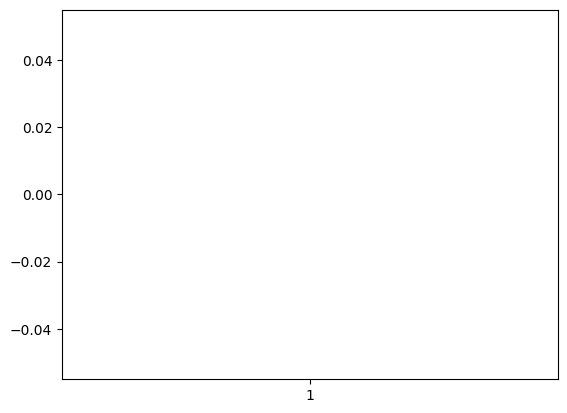

Доля рынка_1.0


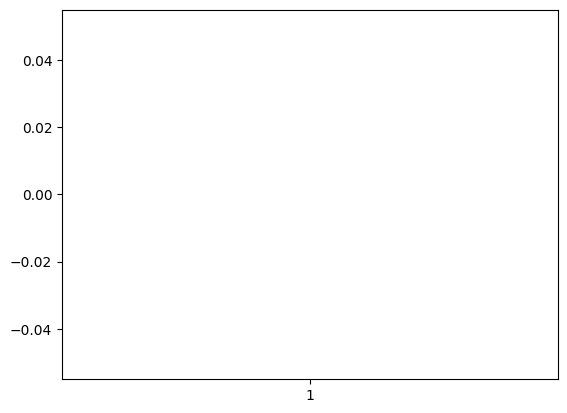

Доля рынка_2.0


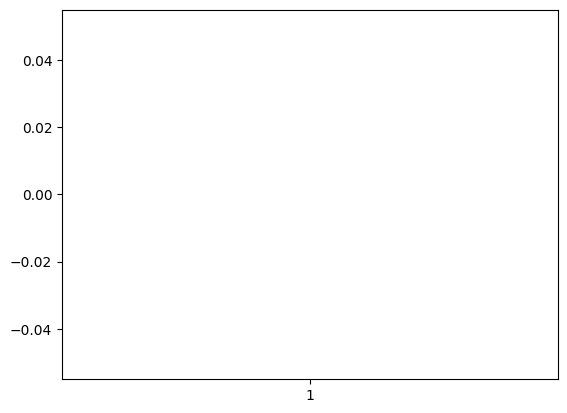

Доля рынка_3.0


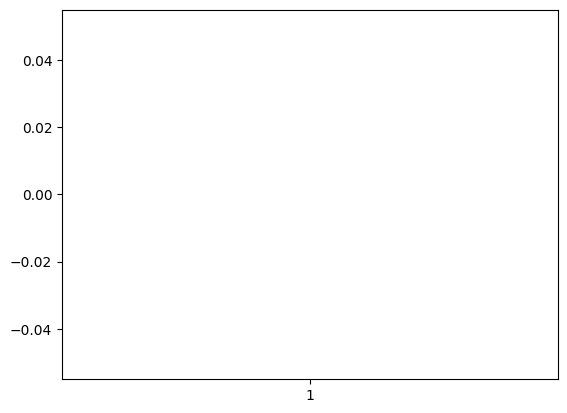

Доля рынка_4.0


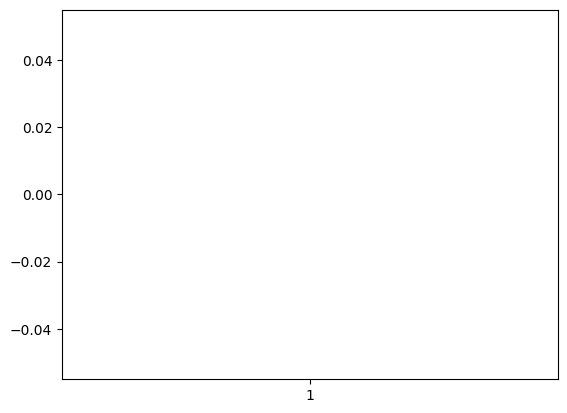

Доля рынка_5.0


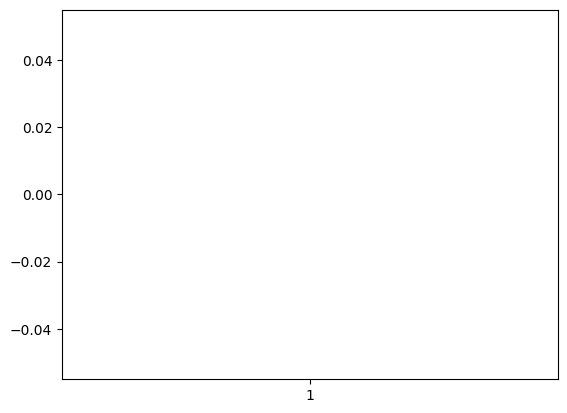

Стабильность доли рынка_0.0


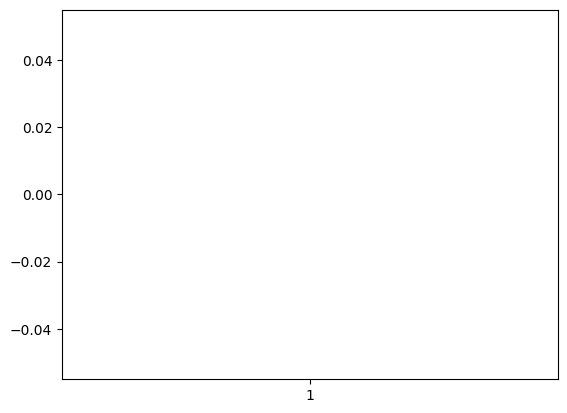

Стабильность доли рынка_0.5


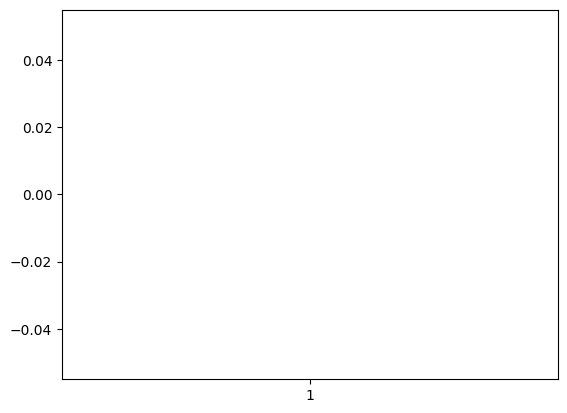

Стабильность доли рынка_1.0


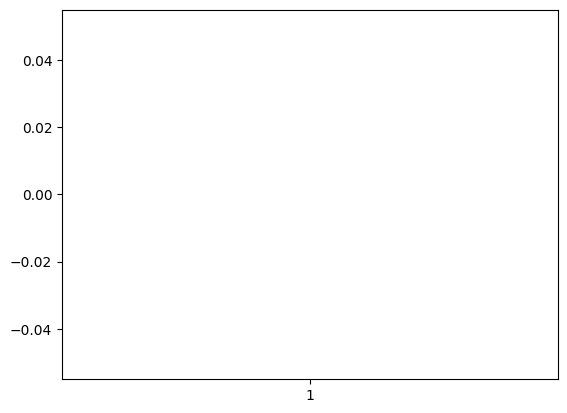

Стабильность доли рынка_1.2


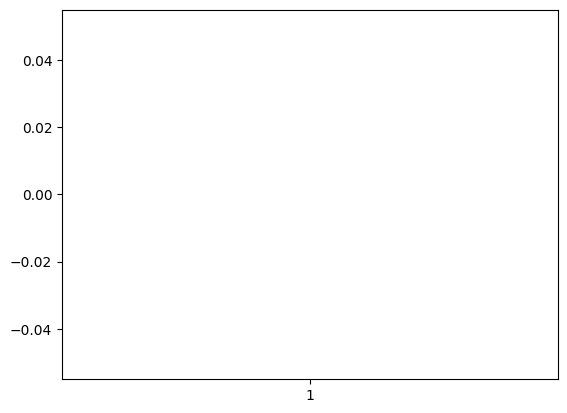

Стабильность доли рынка_1.5


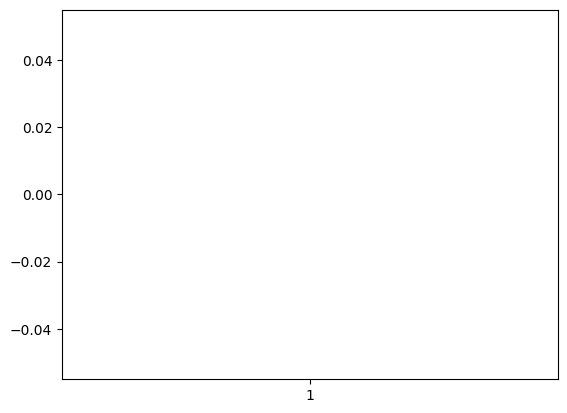

Стабильность доли рынка_1.8


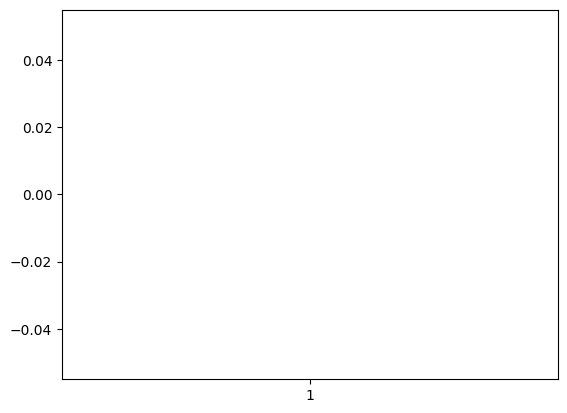

Стабильность доли рынка_2.0


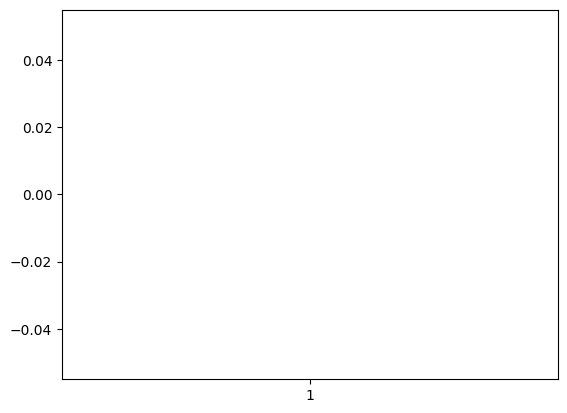

Отклонение темпов роста_0.0


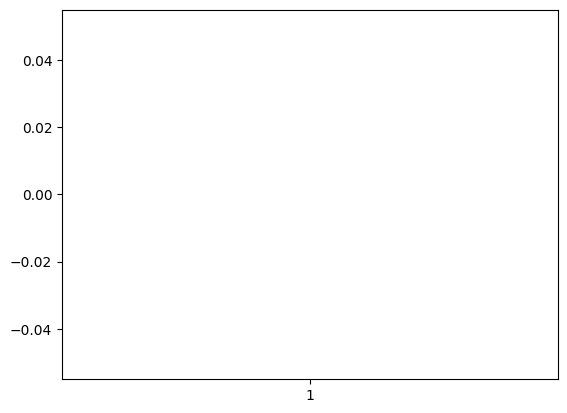

Отклонение темпов роста_0.5


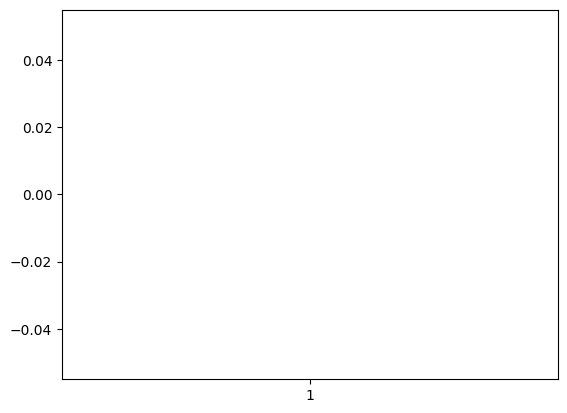

Отклонение темпов роста_1.0


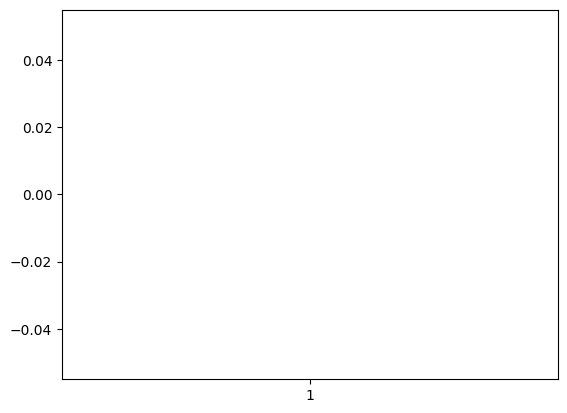

Отклонение темпов роста_1.5


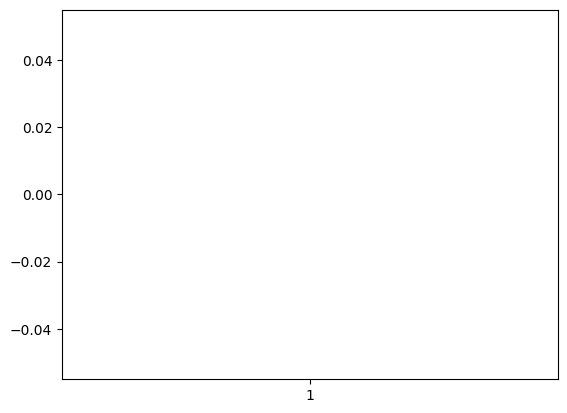

Отклонение темпов роста_2.0


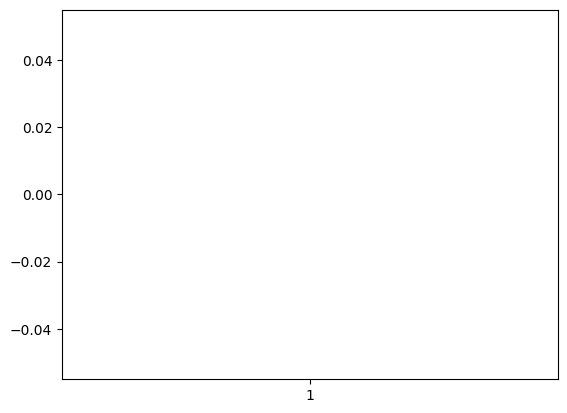

Отклонение темпов роста_2.5


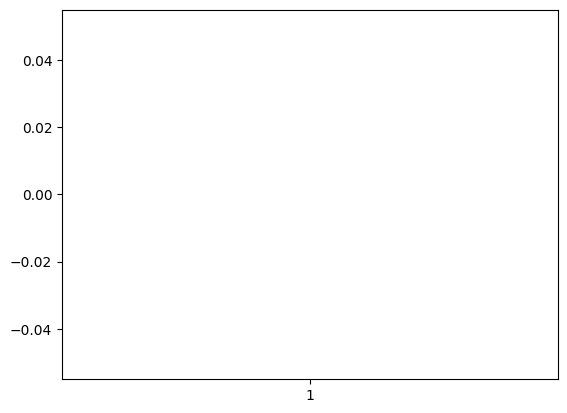

Отклонение темпов роста_3.0


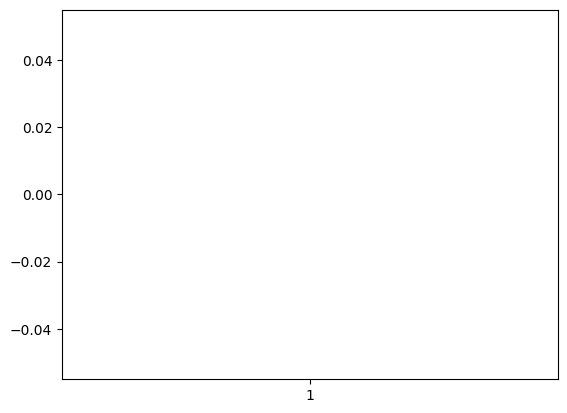

Диверсификация дохода_0.0


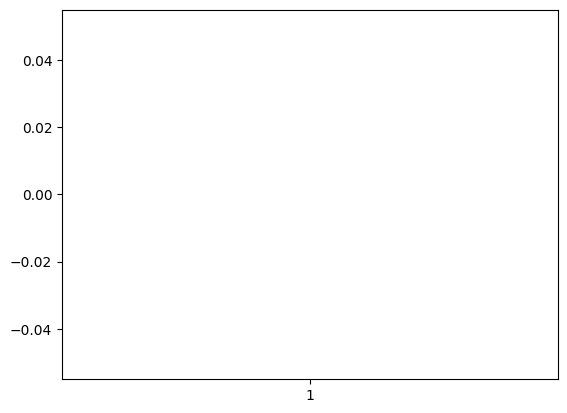

Диверсификация дохода_0.6


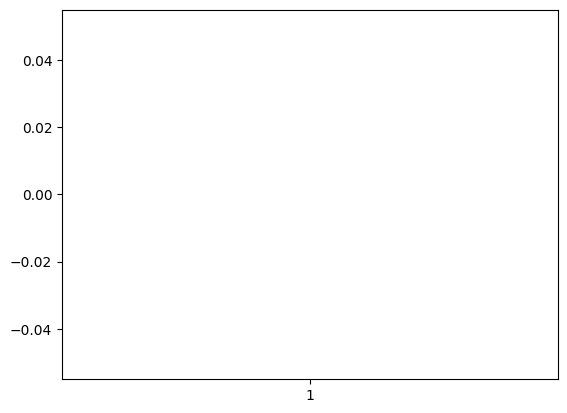

Диверсификация дохода_1.2


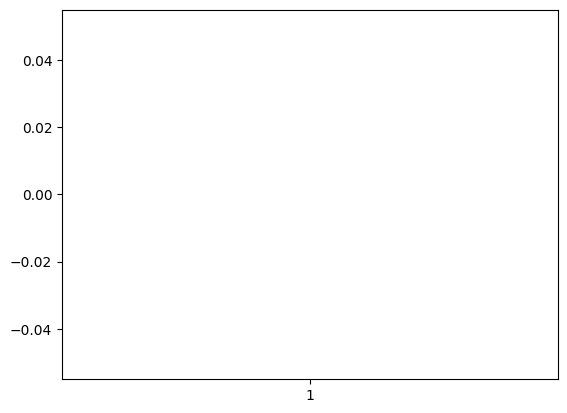

Диверсификация дохода_1.8


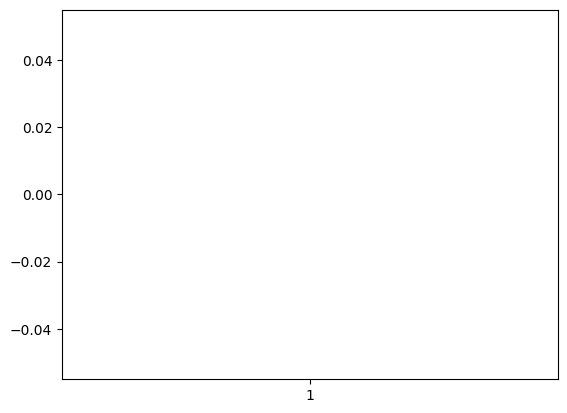

Диверсификация дохода_2.4


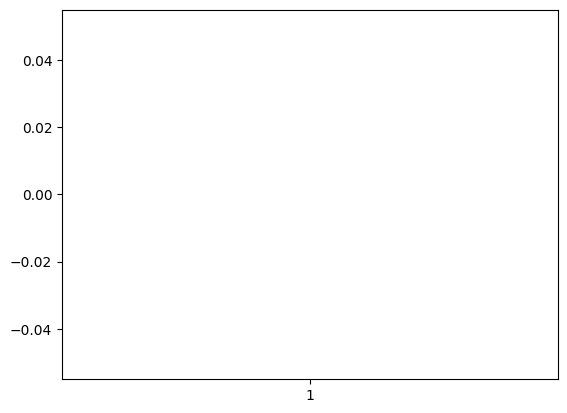

Диверсификация дохода_3.0


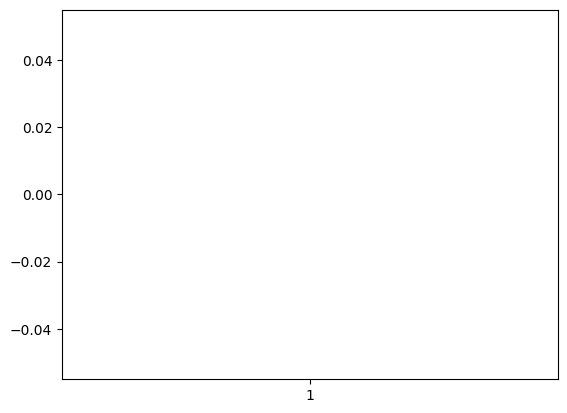

География присутствия_0


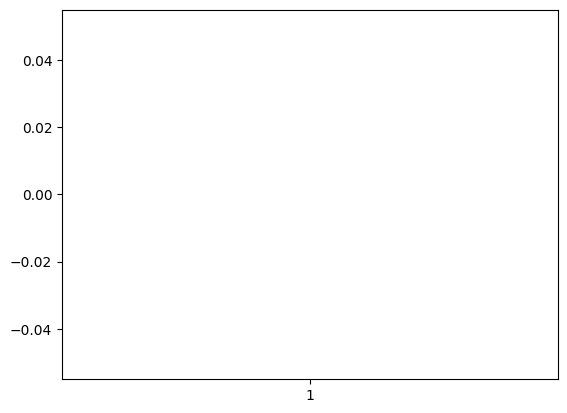

География присутствия_1


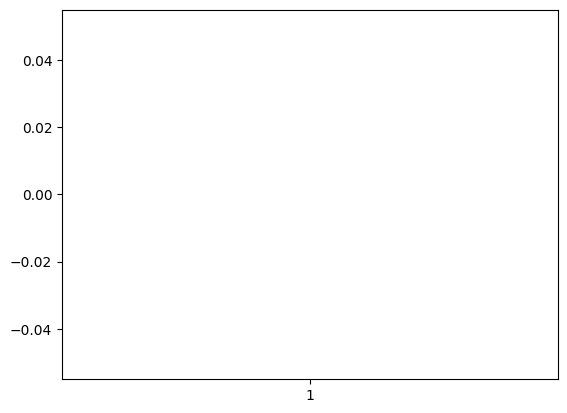

География присутствия_2


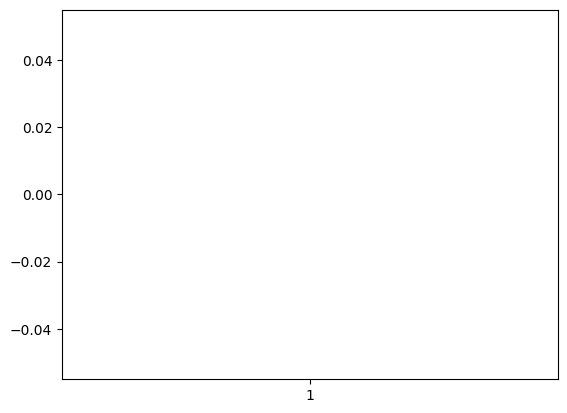

География присутствия_3


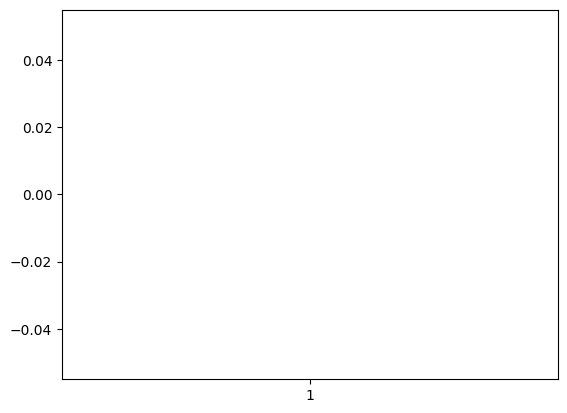

География присутствия_4


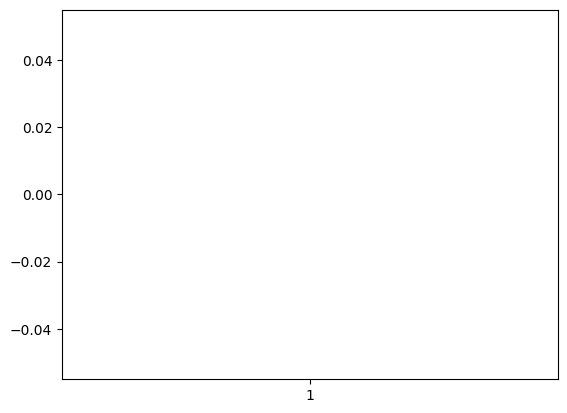

Структура собственности_-1


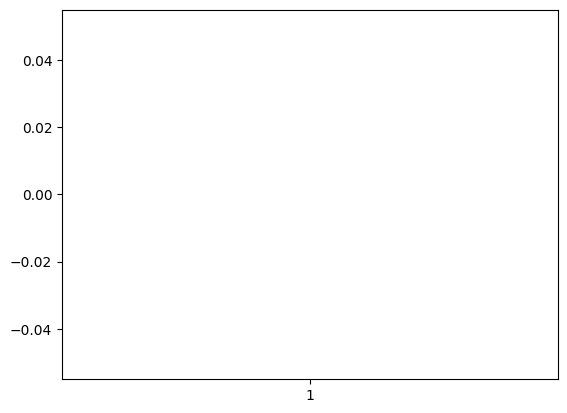

Структура собственности_1


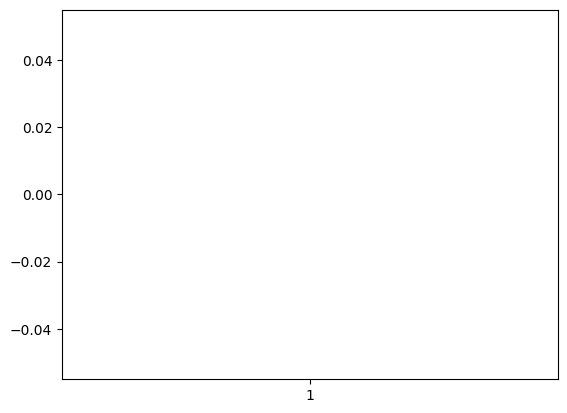

Структура собственности_2


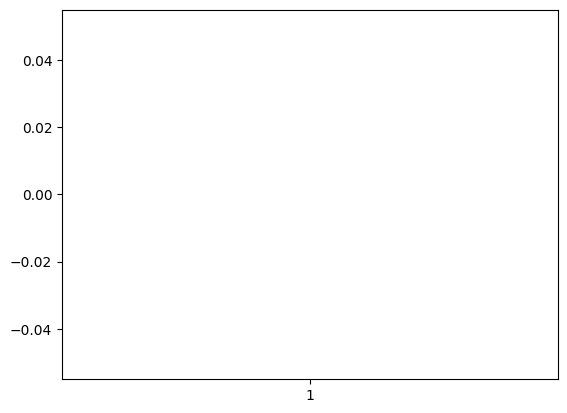

Доля государства_0


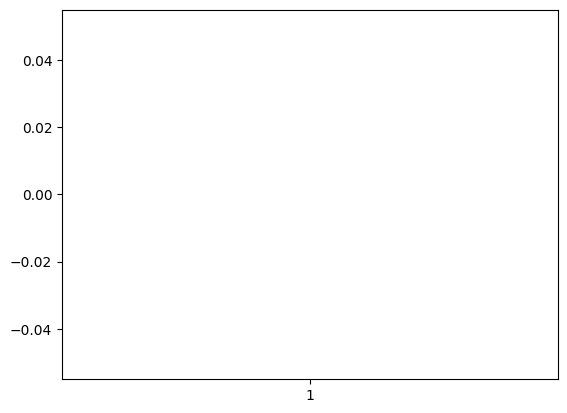

Доля государства_1


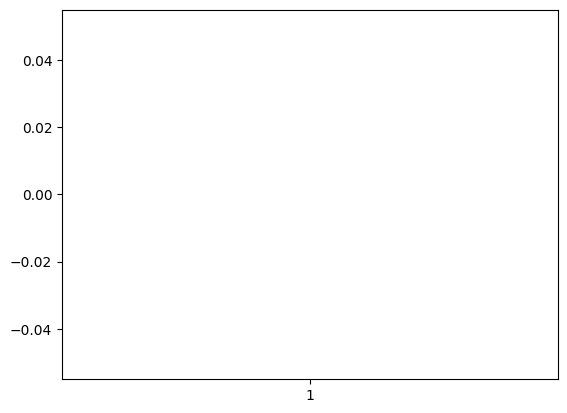

Доля государства_2


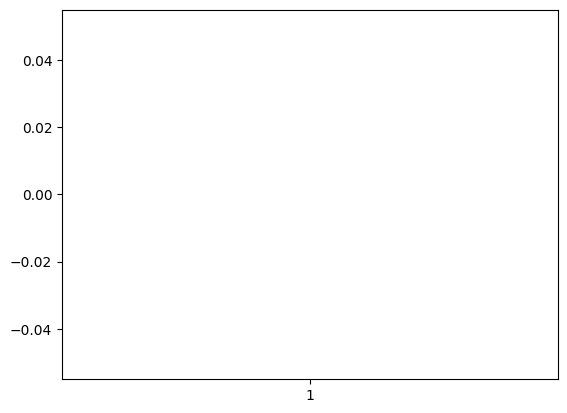

Доля государства_3


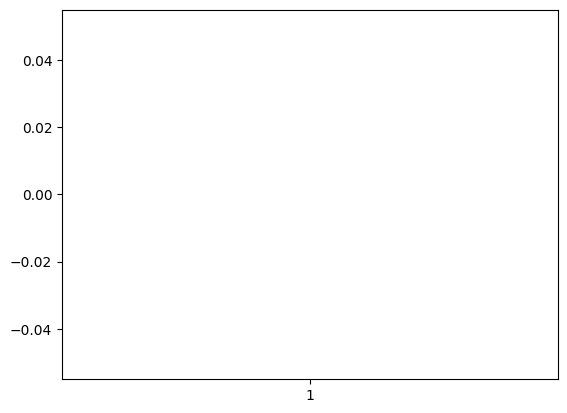

Доля государства_4


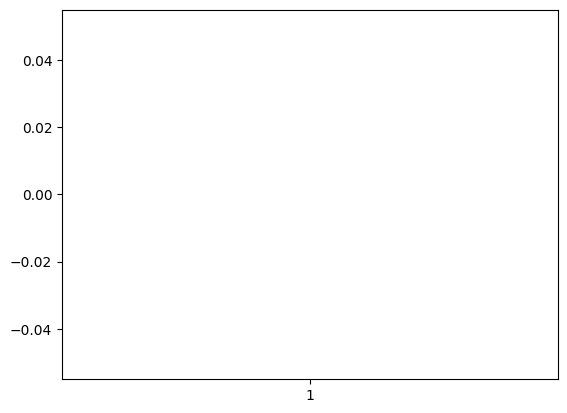

Доля государства_5


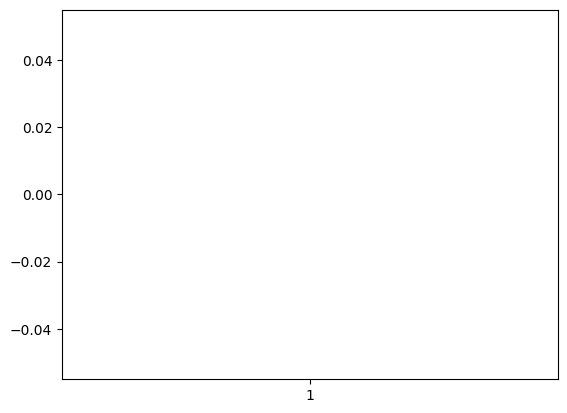

Частные акционеры_0


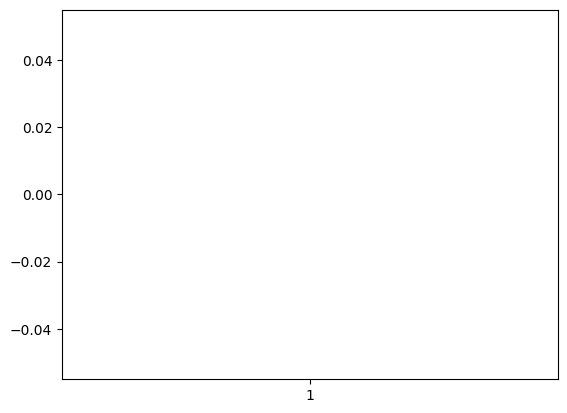

Частные акционеры_1


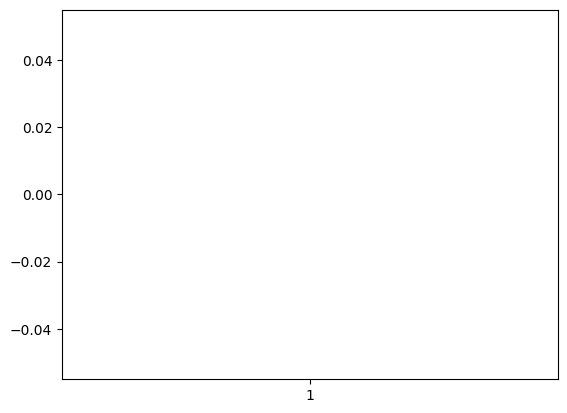

Частные акционеры_2


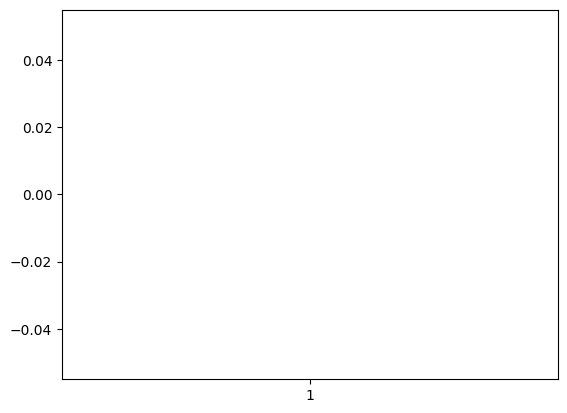

Частные акционеры_3


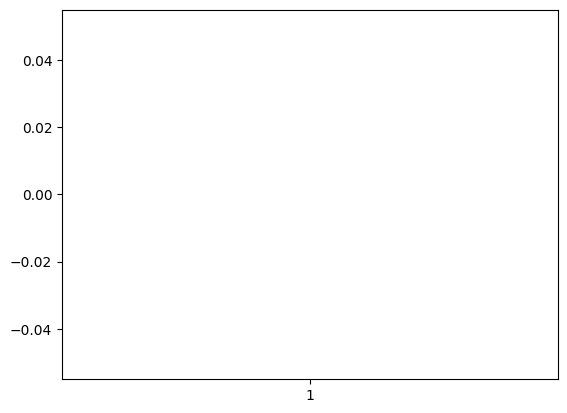

Качество управления_-3.0


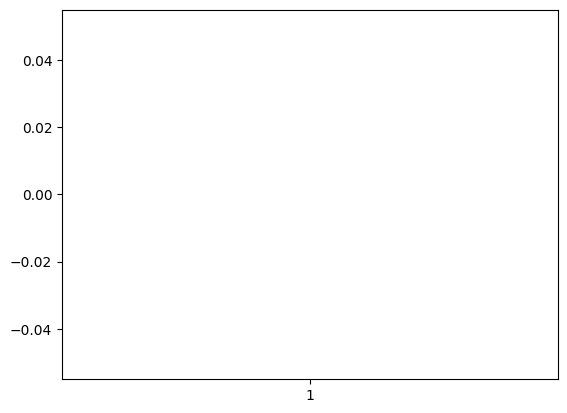

Качество управления_-1.5


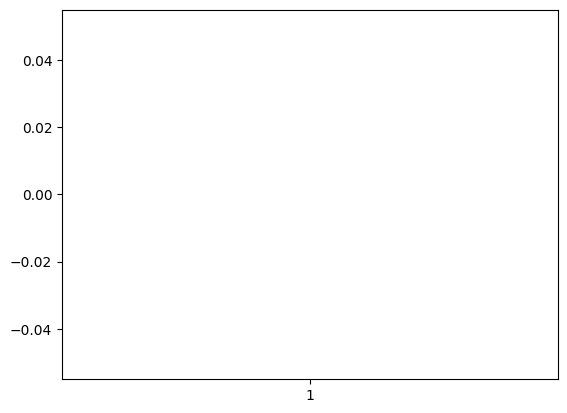

Качество управления_0.0


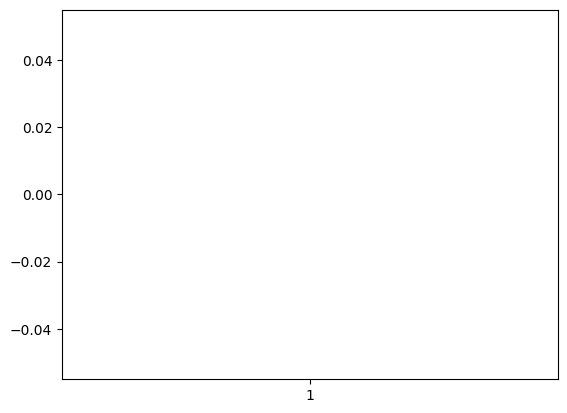

Качество управления_1.5


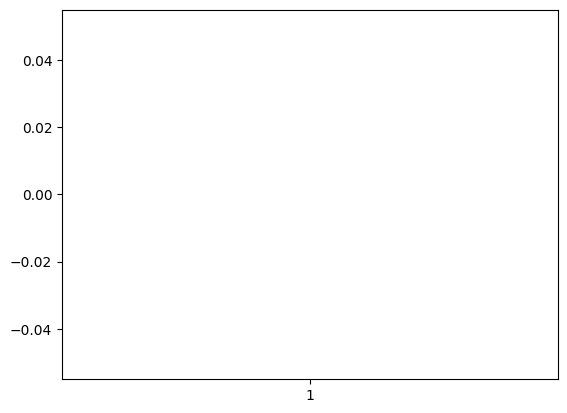

Качество управления_3.0


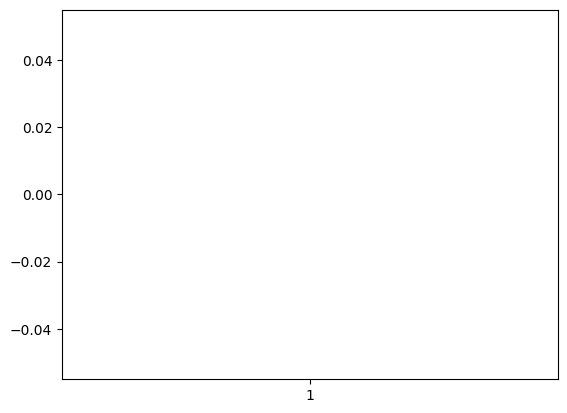

Деловая репутация_-1


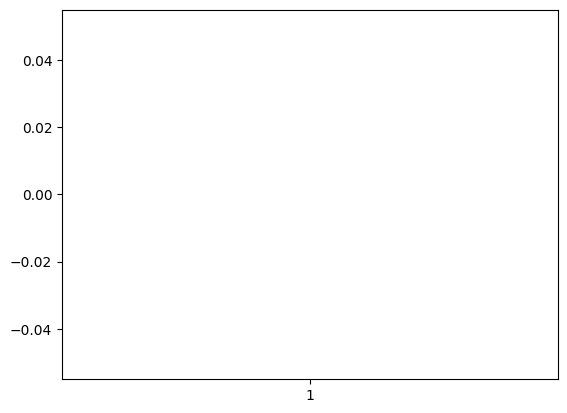

Деловая репутация_0


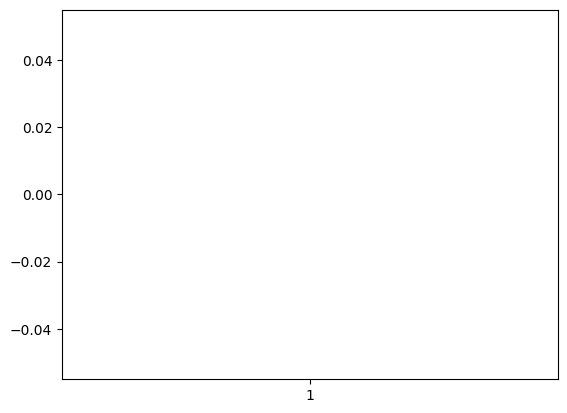

Деловая репутация_1


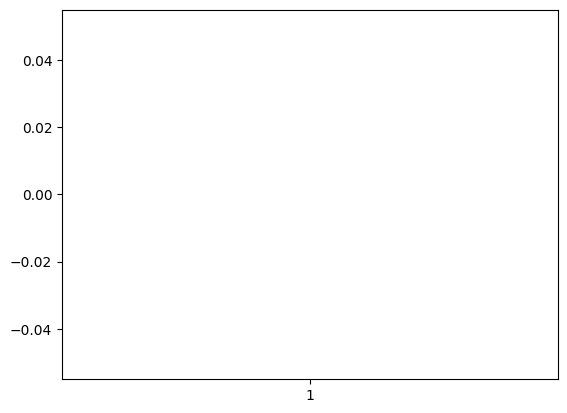

Деловая репутация_2


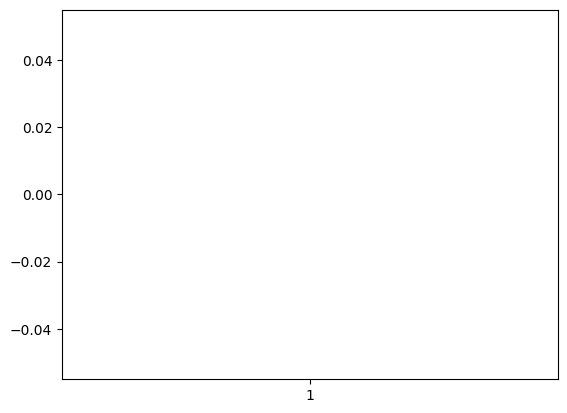

Связанность операций с бизнесом_0


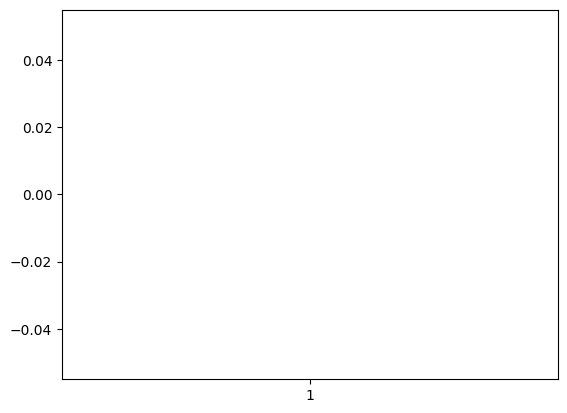

Связанность операций с бизнесом_1


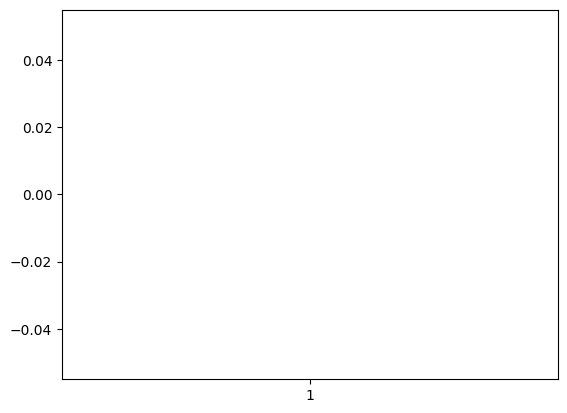

Связанность операций с бизнесом_2


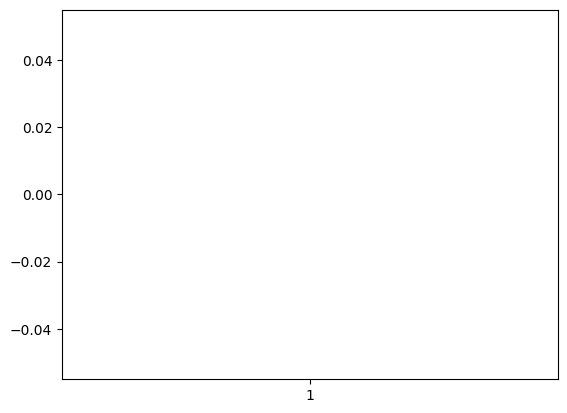

Отчетность МСФО_0


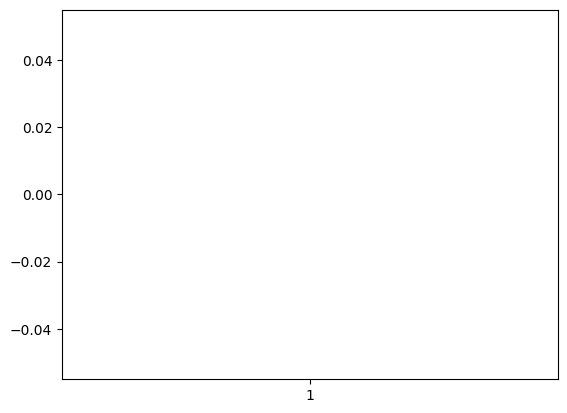

Отчетность МСФО_1


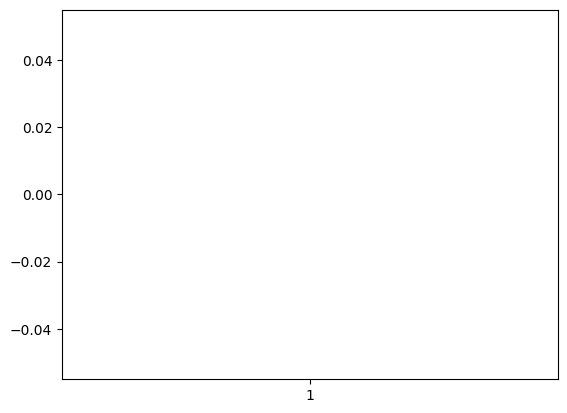

Отчетность МСФО_2


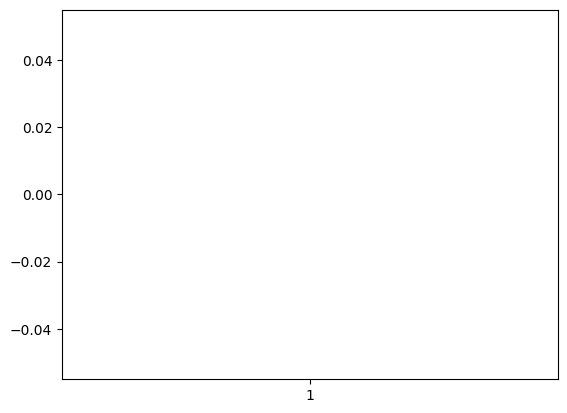

Отчетность МСФО_3


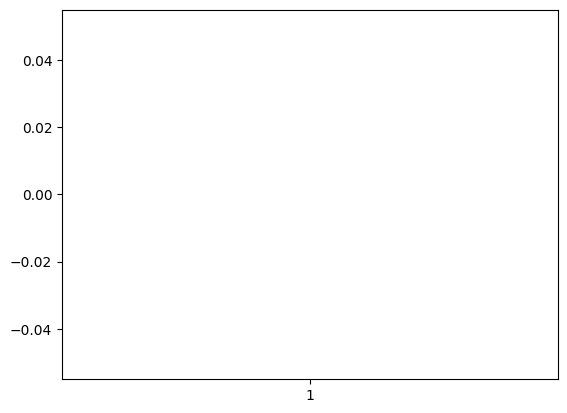

Отчетность МСФО_4


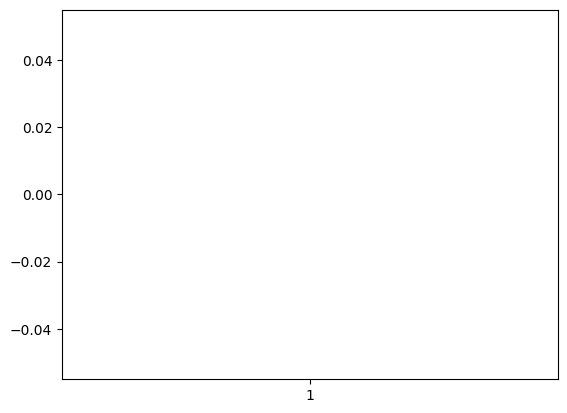

Рейтинги НРА_0.0


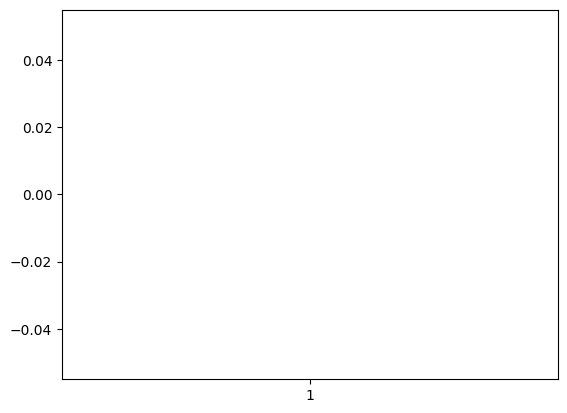

Рейтинги НРА_2.5


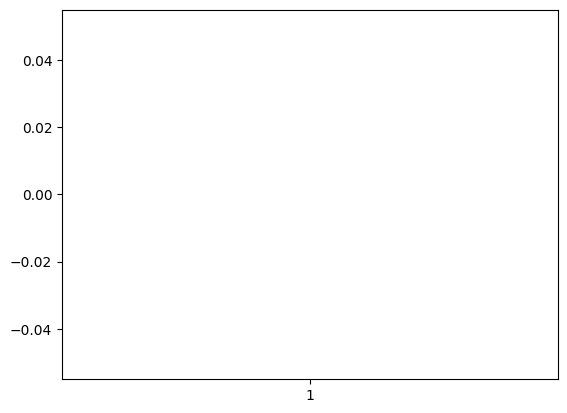

Рейтинги НРА_4.0


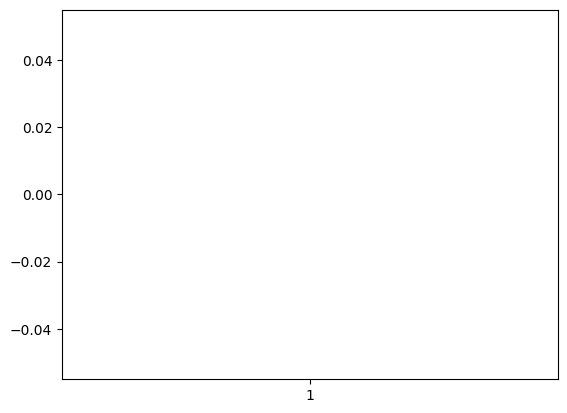

Рейтинги НРА_5.0


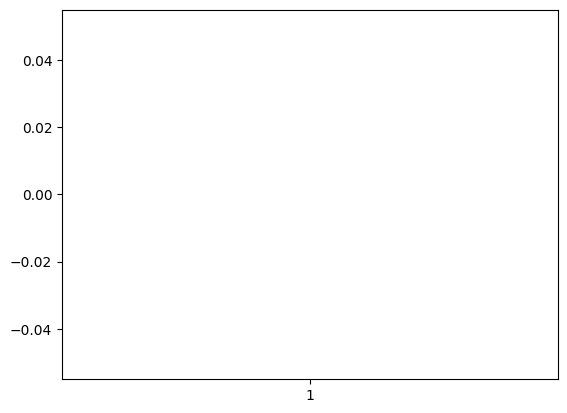

Количество рейтингов НРА (баллы)_1.0


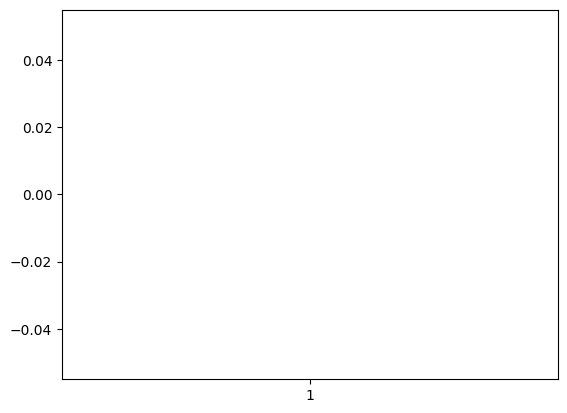

Количество рейтингов НРА (баллы)_1.2


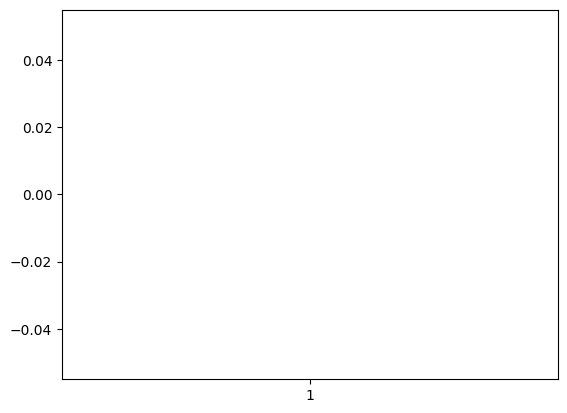

Количество рейтингов НРА (баллы)_2.0


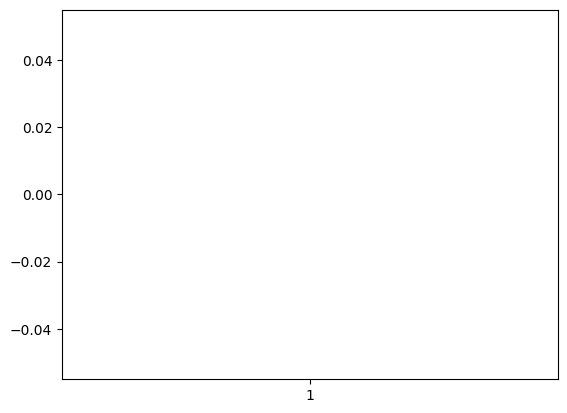

Прогноз по рейтингам НРА_0.0


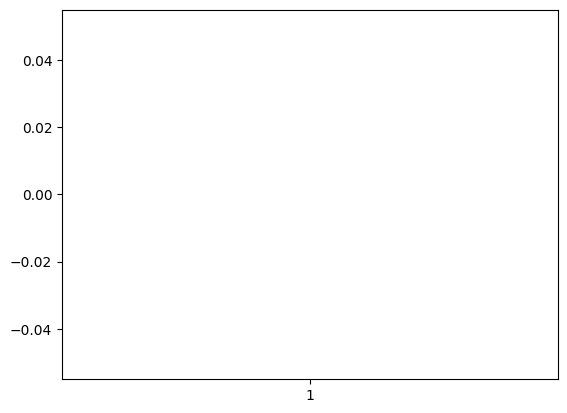

Прогноз по рейтингам НРА_1.2


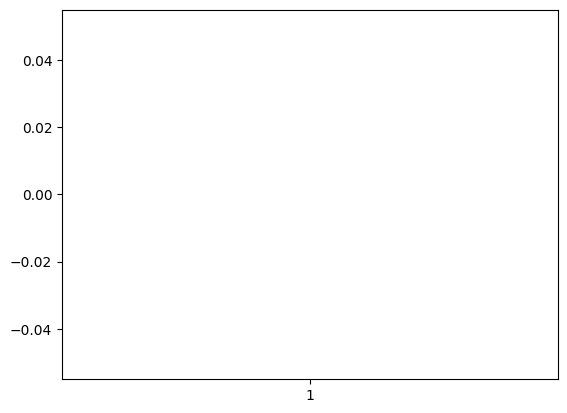

Прогноз по рейтингам НРА_2.0


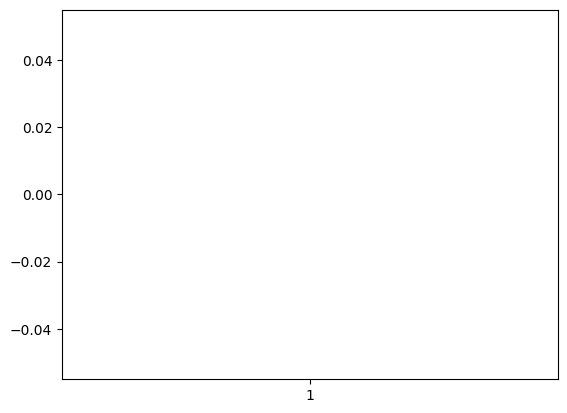

ПОДДЕРЖКА МАКСИМУМ_0


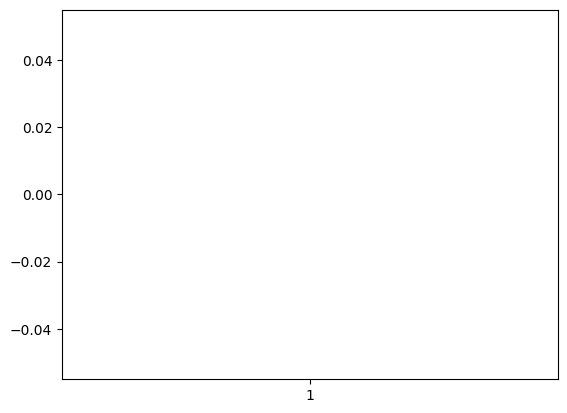

ПОДДЕРЖКА МАКСИМУМ_8


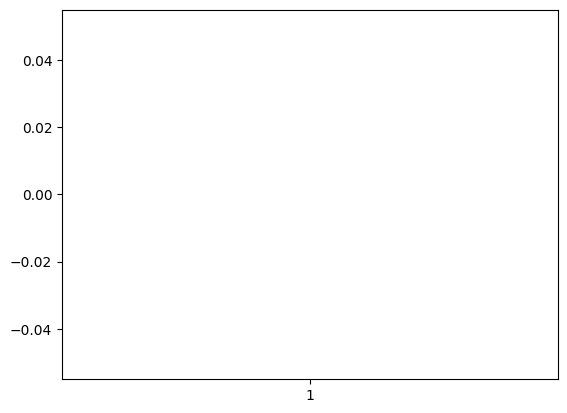

ПОДДЕРЖКА МАКСИМУМ_10


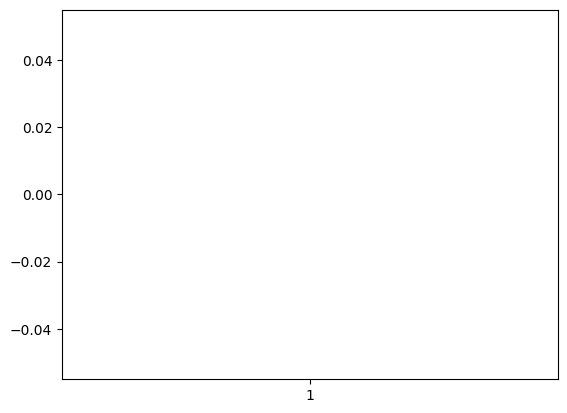

ПОДДЕРЖКА МАКСИМУМ_16


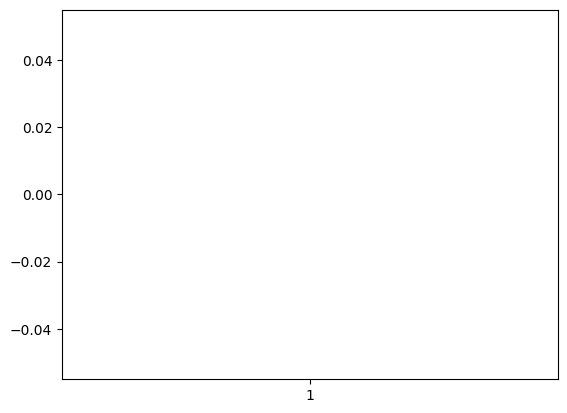

ПОДДЕРЖКА МАКСИМУМ_20


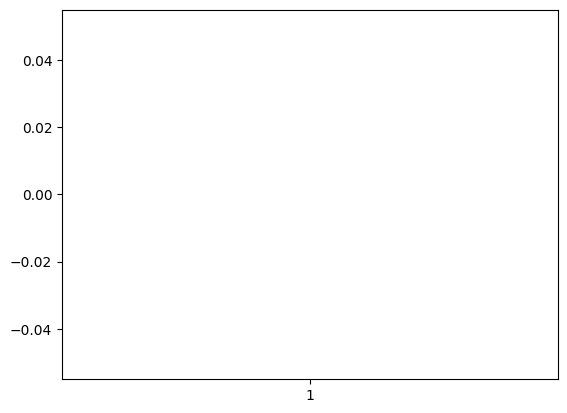

In [35]:
for col in df_cat_drop_train.columns:
    data_col = df_cat_drop_train[col].values
    print(col)
    plt.boxplot(np.log(data_col))
    plt.show()

# Каппа Коэна

In [129]:
# Создание модели решающего дерева
clf = DecisionTreeClassifier(random_state=42)

# Оценка модели с использованием кросс валидации
scores = cross_val_score(clf, df_train, y_train, cv=5)
print(f"Результаты кросс валидации: {scores}")
print(f"Среднее: {scores.mean()}")

# Обучение модели и предсказание
clf.fit(df_train, y_train)
y_pred = clf.predict(df_test)

# Оценка модели на тестовой выборке
kappa_score = cohen_kappa_score(y_test, y_pred)
print(f"На тестовом: {kappa_score}")

Результаты кросс валидации: [0.93560606 0.91666667 0.97727273 0.95454545 0.96590909]
Среднее: 0.95
На тестовом: 0.4076070679844265


In [130]:
# Функция для расчета коэффициента Кендалла
def kendall_tau(y_true, y_pred):
    tau, _ = kendalltau(y_true, y_pred)
    return tau

# Создание модели решающего дерева
clf = DecisionTreeClassifier(random_state=42)

# Оценка модели с использованием кросс-валидации
scores = cross_val_score(clf, df_train, y_train, cv=5)
print(f"Результаты кросс-валидации: {scores}")
print(f"Среднее: {scores.mean()}")

# Обучение модели и предсказание
clf.fit(df_train, y_train)
y_pred = clf.predict(df_test)

# Оценка модели на тестовой выборке с использованием коэффициента Кендалла
kendall_score = kendall_tau(y_test, y_pred)
print(f"На тестовом: {kendall_score}")

Результаты кросс-валидации: [0.93560606 0.91666667 0.97727273 0.95454545 0.96590909]
Среднее: 0.95
На тестовом: 0.7602830204361027


In [131]:
print(accuracy_score(y_test,y_pred))

0.46511627906976744


In [132]:
# Получение значимости признаков
feature_importances = clf.feature_importances_

# Создание датафрейма для удобного отображения
feature_importances_df = pd.DataFrame({
    'Feature': df_cat_drop_train.columns,
    'Importance': feature_importances
})

# Сортировка признаков по важности
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Вывод значимых признаков
print(feature_importances_df)

                                 Feature  Importance
84                      Рейтинги НРА_5.0    0.119599
66               Качество управления_0.0    0.091653
22                        Доля рынка_2.0    0.086414
1            1.2. Доля средств населения    0.076753
83                      Рейтинги НРА_4.0    0.076685
..                                   ...         ...
54                    Доля государства_0    0.000000
55                    Доля государства_1    0.000000
56                    Доля государства_2    0.000000
25                        Доля рынка_5.0    0.000000
12  4.2. Коэффициент процентных расходов    0.000000

[96 rows x 2 columns]


In [133]:
feature_importances_df[:24]

,Feature,Importance
84,Рейтинги НРА_5.0,0.119599
66,Качество управления_0.0,0.091653
22,Доля рынка_2.0,0.086414
1,1.2. Доля средств населения,0.076753
83,Рейтинги НРА_4.0,0.076685
60,Частные акционеры_0,0.072309
50,География присутствия_4,0.057109
16,5.3. Отношение NPL к Капиталу (1.2),0.048304
43,Диверсификация дохода_1.8,0.037084
17,5.4. Коэффициент резервирования,0.036502


## Через другие методы

In [44]:
from sklearn.inspection import permutation_importance

# Обучаем модель
# clf.fit(df_train, y_train)

# Оценка важности признаков методом перестановок
result = permutation_importance(clf, df_train, y_train, n_repeats=10, random_state=42, scoring=kendall_scorer)

# Создание датафрейма для удобного отображения
permutation_importance_df = pd.DataFrame({
    'Feature': df_cat_drop_train.columns,
    'Importance': result.importances_mean
})

# Сортировка признаков по важности
permutation_importance_df = permutation_importance_df.sort_values(by='Importance', ascending=False)

# Вывод значимых признаков
print(permutation_importance_df)

                        Feature  Importance
84             Рейтинги НРА_5.0    0.565212
83             Рейтинги НРА_4.0    0.141984
60          Частные акционеры_0    0.086333
1   1.2. Доля средств населения    0.080507
63          Частные акционеры_3    0.063017
..                          ...         ...
38  Отклонение темпов роста_2.5    0.000000
37  Отклонение темпов роста_2.0    0.000000
36  Отклонение темпов роста_1.5    0.000000
35  Отклонение темпов роста_1.0    0.000000
95        ПОДДЕРЖКА МАКСИМУМ_20    0.000000

[96 rows x 2 columns]


In [45]:
from sklearn.metrics import accuracy_score
# Функция для расчета коэффициента Кендалла
def kendall_tau(y_true, y_pred):
    tau, _ = kendalltau(y_true, y_pred)
    return tau

# Создание кастомной метрики на основе коэффициента Кендалла
kendall_scorer = make_scorer(kendall_tau)

# Создание модели решающего дерева
clf = DecisionTreeClassifier(random_state=42)

# Обучение модели и предсказание
clf.fit(df_train, y_train)
y_pred = clf.predict(df_test)

# Оценка модели на тестовой выборке с использованием коэффициента Кендалла
baseline_score = kendall_tau(y_test, y_pred)
base_col_name = ''
final_columns = []
print('+ значения говорят о положительном влиянии признака, - об отрицательном')

for col in df_cat_drop.columns:
    # Исключаем признак и обучаем модель снова
    # Находим все столбцы, которые содержат ту же часть названия до первого подчеркивания или пробела
    if base_col_name != col.split('_')[0]:
        base_col_name = col.split('_')[0]
        feature_to_drop = [c for c in df_cat_drop.columns if c.startswith(base_col_name)]
        
        df_train_dropped = df_cat_drop_train.drop(columns=feature_to_drop)
        df_test_dropped = df_cat_drop_test.drop(columns=feature_to_drop)
        
        clf.fit(df_train_dropped, y_train)
        y_pred_dropped = clf.predict(df_test_dropped)
        new_score = kendall_tau(y_test, y_pred_dropped)
        
        # Оценка влияния признака
        impact = baseline_score - new_score
        if impact > 0:
            final_columns.extend(feature_to_drop)
        print(f"Влияние признака {base_col_name} на модель: {impact}")

+ значения говорят о положительном влиянии признака, - об отрицательном
Влияние признака 1.1. Отношение кредитов к депозитам (LDR) на модель: -0.003828286457871033
Влияние признака 1.2. Доля средств населения на модель: 0.0032414675846293983
Влияние признака 1.3. Надежность банка на модель: -0.001963002111864176
Влияние признака 1.4. Норматив мгновенной ликвидности на модель: 0.004713570483260265
Влияние признака 1.5. Норматив текущей ликвидности на модель: 0.006285819866766906
Влияние признака 2.1. Достаточность собственных средств на модель: 0.01119223567742833
Влияние признака 2.2. Достаточность основного капитала на модель: -0.009513170620002565
Влияние признака 2.3. Устойчивость капитала на модель: -0.005102096457125338
Влияние признака 2.4. Доля основного капитала в общем капитале на модель: -0.004454546968114426
Влияние признака 3.1. ROE на модель: -0.004454546968114426
Влияние признака 3.2. ROA на модель: -0.004454546968114426
Влияние признака 4.1. Коэффициент процентных доходо

## Нашли более значимые столбцы, оставим только c значимостью больше 0.01

In [173]:
feature_importances_df['Feature']

84                        Рейтинги НРА_5.0
66                 Качество управления_0.0
22                          Доля рынка_2.0
1              1.2. Доля средств населения
83                        Рейтинги НРА_4.0
                      ...                 
54                      Доля государства_0
55                      Доля государства_1
56                      Доля государства_2
25                          Доля рынка_5.0
12    4.2. Коэффициент процентных расходов
Name: Feature, Length: 96, dtype: object

In [174]:
important_cols = feature_importances_df['Feature'].iloc[:24].values

In [175]:
important_cols

array(['Рейтинги НРА_5.0', 'Качество управления_0.0', 'Доля рынка_2.0',
       '1.2. Доля средств населения', 'Рейтинги НРА_4.0',
       'Частные акционеры_0', 'География присутствия_4',
       '5.3. Отношение NPL к Капиталу  (1.2)',
       'Диверсификация дохода_1.8', '5.4. Коэффициент резервирования',
       'Диверсификация дохода_0.0', 'ПОДДЕРЖКА МАКСИМУМ_20',
       '2.2. Достаточность основного капитала', '5.5. Стоимость риска',
       '1.5. Норматив текущей ликвидности',
       'Связанность операций с бизнесом_1', 'Качество управления_3.0',
       'Доля государства_3', '4.3. Доля операционных расходов в доходах',
       'Отклонение темпов роста_1.0',
       '1.4. Норматив мгновенной ликвидности', 'ПОДДЕРЖКА МАКСИМУМ_10',
       '1.3. Надежность банка', 'География присутствия_2'], dtype=object)

In [176]:
# Пройтись по всем значимым столбцам
final_columns = []
for col in important_cols:
    # Находим все столбцы, которые содержат ту же часть названия до первого подчеркивания или пробела
    base_col_name = col.split('_')[0]
    matching_columns = [c for c in df_cat_drop_train.columns if c.startswith(base_col_name)]
    final_columns.extend(matching_columns)

In [177]:
# Удаление дубликатов в случае повторения столбцов
final_columns = sorted(list(set(final_columns)))

In [178]:
# Отфильтруем датасет, оставив только итоговые столбцы
df_important_train = df_cat_drop_train[final_columns]
df_important_test = df_cat_drop_test[final_columns]
df_train_important = df_important_train.values
df_test_important = df_important_test.values

In [179]:
# Функция для расчета коэффициента Кендалла
def kendall_tau(y_true, y_pred):
    tau, _ = kendalltau(y_true, y_pred)
    return tau
    
# Создание кастомной метрики на основе коэффициента Кендалла
kendall_scorer = make_scorer(kendall_tau)

In [180]:
results = []

# Итерация по глубине
for depth in range(1, 16):
    # Создание модели решающего дерева с указанной глубиной
    clf = DecisionTreeClassifier(random_state=42, max_depth=depth)
    
    # Обучение модели и предсказание
    clf.fit(df_train_important, y_train)
    y_pred = clf.predict(df_test_important)
    
    # Оценка модели с использованием коэффициента Кендалла
    kendall_score = kendall_tau(y_test.flatten(), y_pred)
    
    # Оценка модели с использованием коэффициента Каппа Коэна
    cohen_kappa = cohen_kappa_score(y_test.flatten(), y_pred)
    
    # RMSE
    squared_diffs = (y_test.flatten() - y_pred) ** 2
    rmse = np.sqrt(np.mean(squared_diffs)).item()
    
    # Количество предсказаний с разницей
    diff = y_test.flatten() - y_pred
    counts = {
        '-2': np.sum(diff <= -2),
        '-1': np.sum(diff == -1),
        '0': np.sum(diff == 0),
        '1': np.sum(diff == 1),
        '2': np.sum(diff >= 2),
    }
    
    # Добавляем данные в таблицу
    results.append({
        'Глубина': depth,
        'Кендалл': kendall_score,
        'Каппа': cohen_kappa,
        'RMSE': rmse,
        '_-2': counts['-2'],
        '-1': counts['-1'],
        '(0)': counts['0'],
        '+1': counts['1'],
        '+2_': counts['2']
    })

results_df = pd.DataFrame(results)

In [190]:
results_df

,Глубина,Кендалл,Каппа,RMSE,_-2,-1,(0),+1,+2_
0,1,0.690447,0.064268,3.718277,26,12,11,19,18
1,2,0.802193,0.186672,3.603938,26,15,21,20,4
2,3,0.736427,0.327232,4.074881,28,8,33,13,4
3,4,0.739491,0.332736,4.124515,32,9,34,9,2
4,5,0.717525,0.345568,4.201329,33,9,35,6,3
5,6,0.773256,0.380273,4.087701,34,9,38,4,1
6,7,0.763702,0.420225,4.094807,33,5,41,4,3
7,8,0.754389,0.370763,4.057723,33,9,37,5,2
8,9,0.760127,0.394275,4.023189,33,6,39,5,3
9,10,0.769023,0.419529,4.015957,32,5,41,5,3


In [188]:
predict_df = pd.DataFrame()
predict_df.index = df_category_test.index
predict_df['Real'] = y_test
predict_df['Predict'] = y_pred

In [192]:
len(y_test[y_test==1])

26

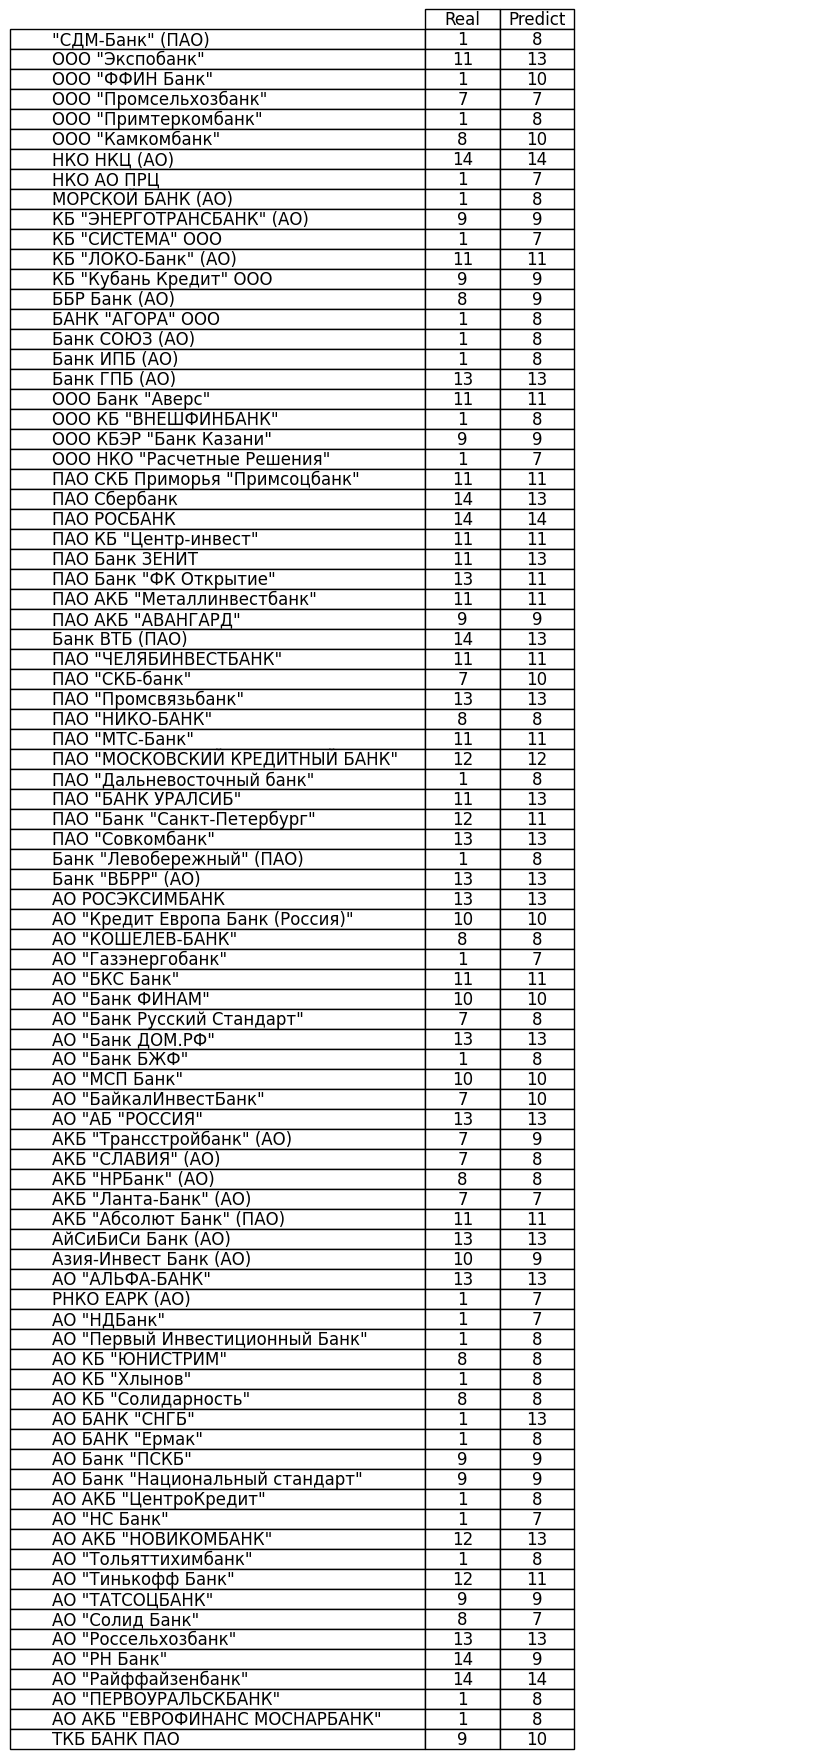

In [189]:
# Создаем фигуру и оси
fig, ax = plt.subplots(figsize=(8, 4))  # Указываем размер изображения

# Скрываем оси
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 
ax.set_frame_on(False)  # Убираем рамку

# Отображаем DataFrame в виде таблицы
tabla = pd.plotting.table(ax, predict_df, loc='center', cellLoc='center', colWidths=[0.1]*len(df.columns))

# Настраиваем размер шрифта в таблице
tabla.auto_set_font_size(False)
tabla.set_fontsize(12)
tabla.scale(1.2, 1.2)

# Сохраняем таблицу как изображение
plt.savefig("dataframe_image.png", bbox_inches='tight', dpi=300)
plt.show()

In [40]:
import graphviz
# Обучение модели
clf = DecisionTreeClassifier(random_state=42, max_depth=7)
clf.fit(df_train_important, y_train)

# Экспортируем дерево в формат dot
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=final_columns,   
                           class_names=['7', '8', '9', '10', '11', '12', '13', '14'], 
                           filled=True, rounded=True,  
                           special_characters=True)

# Генерируем изображение дерева
graph = graphviz.Source(dot_data)
graph.render("tree1")  # Сохранение в файл tree.pdf

# Визуализация
graph.view()

'tree1.pdf'

In [41]:
# Получение значимости признаков
feature_importances = clf.feature_importances_

# Создание датафрейма для удобного отображения
feature_importances_df = pd.DataFrame({
    'Feature': final_columns,
    'Importance': feature_importances
})

# Сортировка признаков по важности
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Вывод значимых признаков
print(feature_importances_df)

                        Feature  Importance
53             Рейтинги НРА_5.0    0.122234
35      Качество управления_0.0    0.093672
0   1.2. Доля средств населения    0.090276
29               Доля рынка_2.0    0.088318
52             Рейтинги НРА_4.0    0.078375
..                          ...         ...
16    Диверсификация дохода_1.2    0.000000
38  Отклонение темпов роста_0.0    0.000000
39  Отклонение темпов роста_0.5    0.000000
20           Доля государства_0    0.000000
30               Доля рынка_3.0    0.000000

[61 rows x 2 columns]


In [42]:
feature_importances_df[:29]

,Feature,Importance
53,Рейтинги НРА_5.0,0.122234
35,Качество управления_0.0,0.093672
0,1.2. Доля средств населения,0.090276
29,Доля рынка_2.0,0.088318
52,Рейтинги НРА_4.0,0.078375
57,Частные акционеры_0,0.073902
6,5.3. Отношение NPL к Капиталу (1.2),0.067270
13,География присутствия_4,0.061693
17,Диверсификация дохода_1.8,0.037901
14,Диверсификация дохода_0.0,0.036201


## Стресс тест контрагента

In [34]:
# df_category_stress = df_category[df_category.index.str.contains('Примсоцбанк', case=False, na=False)]
# df_category_test = df_category[df_category.index.str.contains('Примсоцбанк', case=False, na=False)]
df_category_stress = df_category_test[df_category_test.index.str.contains('Примсоцбанк', case=False, na=False)]
df_category_real = df_category_test[df_category_test.index.str.contains('Примсоцбанк', case=False, na=False)]

In [35]:
df_category_test.columns

Index(['1.1. Отношение кредитов к депозитам (LDR)',
       '1.2. Доля средств населения', '1.3. Надежность банка',
       '1.4. Норматив мгновенной ликвидности',
       '1.5. Норматив текущей ликвидности',
       '2.1. Достаточность собственных средств',
       '2.2. Достаточность основного капитала', '2.3. Устойчивость капитала',
       '2.4. Доля основного капитала в общем капитале', '3.1. ROE', '3.2. ROA',
       '4.1. Коэффициент процентных доходов',
       '4.2. Коэффициент процентных расходов',
       '4.3. Доля операционных расходов в доходах', '5.1. Прирост кредитов',
       '5.2. Уровень просроченной задолженности',
       '5.3. Отношение NPL к Капиталу  (1.2)',
       '5.4. Коэффициент резервирования', '5.5. Стоимость риска',
       'External_rating', 'report_date', 'flag', 'Доля рынка_0.0',
       'Доля рынка_0.5', 'Доля рынка_1.0', 'Доля рынка_2.0', 'Доля рынка_3.0',
       'Доля рынка_4.0', 'Доля рынка_5.0', 'Стабильность доли рынка_0.0',
       'Стабильность доли рынка_0.

### Стрессим долю средств населения

In [36]:
# df_category_stress['1.1. Отношение кредитов к депозитам (LDR)'] = 95
# df_category_stress['2.1. Достаточность собственных средств'] = 0
# df_category_stress['2.2. Достаточность основного капитала'] = 0
# df_category_stress['5.1. Прирост кредитов'] = 0
# df_category_stress['5.2. Уровень просроченной задолженности'] = 50

df_category_stress['1.2. Доля средств населения'] = 30

C:\Users\mikhe\AppData\Local\Temp\ipykernel_580\954439145.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_category_stress['1.2. Доля средств населения'] = 30


In [37]:
y_stress = df_category_stress['External_rating'].values.reshape(-1, 1)

In [38]:
df_category_stress = df_category_stress.drop("External_rating", axis = 1) 
df_category_real = df_category_real.drop("External_rating", axis = 1) 

df_category_stress = df_category_stress.drop("report_date", axis = 1)
df_category_real = df_category_real.drop("report_date", axis = 1)

df_cat_drop_stress = df_category_stress.drop("flag", axis=1)
df_cat_drop_real = df_category_real.drop("flag", axis=1)

In [39]:
df_stress = df_cat_drop_stress.values
df_real = df_cat_drop_real.values

In [40]:
# Отфильтруем датасет, оставив только итоговые столбцы
df_important_stress = df_cat_drop_stress[final_columns]
df_stress_important = df_important_stress.values

df_important_real = df_cat_drop_real[final_columns]
df_real_important = df_important_real.values

In [41]:
# Создание модели решающего дерева с указанной глубиной
clf = DecisionTreeClassifier(random_state=42, max_depth=6)
    
# Обучение модели и предсказание
clf.fit(df_train_important, y_train)
# Стрессовый прогноз
y_pred_stress = clf.predict(df_stress_important)
# Обычный прогноз
y_pred_common = clf.predict(df_real_important)

In [42]:
print('Стрессовый прогноз')
print(y_pred_stress)

Стрессовый прогноз
[13 13 13 13 13 13 13 13]


In [43]:
print('Обычный прогноз')
print(y_pred_common)

Обычный прогноз
[11 11 11 11 11 11 11 11]


In [44]:
print('Истинный рейтинг')
print(y_stress.flatten())

Истинный рейтинг
[11 11 11 11 11 11 11 11]


In [45]:
df_category_test[df_category_test.index.str.contains('Прим', case=False, na=True)]

,1.1. Отношение кредитов к депозитам (LDR),1.2. Доля средств населения,1.3. Надежность банка,1.4. Норматив мгновенной ликвидности,1.5. Норматив текущей ликвидности,2.1. Достаточность собственных средств,2.2. Достаточность основного капитала,2.3. Устойчивость капитала,2.4. Доля основного капитала в общем капитале,3.1. ROE,...,Количество рейтингов НРА (баллы)_1.2,Количество рейтингов НРА (баллы)_2.0,Прогноз по рейтингам НРА_0.0,Прогноз по рейтингам НРА_1.2,Прогноз по рейтингам НРА_2.0,ПОДДЕРЖКА МАКСИМУМ_0,ПОДДЕРЖКА МАКСИМУМ_8,ПОДДЕРЖКА МАКСИМУМ_10,ПОДДЕРЖКА МАКСИМУМ_16,ПОДДЕРЖКА МАКСИМУМ_20
"ПАО СКБ Приморья ""Примсоцбанк""",78.551598,49.964797,134.682138,87.177,99.796,9.729464,8.144055,74.884751,83.705068,34.236343,...,0,0,0,1,0,1,0,0,0,0
"ПАО СКБ Приморья ""Примсоцбанк""",76.214106,49.139201,139.364983,87.177,99.796,9.823668,8.040530,95.015747,81.848550,33.553047,...,0,0,0,1,0,1,0,0,0,0
"ПАО СКБ Приморья ""Примсоцбанк""",74.829899,48.741542,140.304639,87.177,99.796,10.039771,8.015836,107.852142,79.840825,34.829777,...,0,0,0,1,0,1,0,0,0,0
"ПАО СКБ Приморья ""Примсоцбанк""",76.383429,49.888004,143.487678,87.177,100.215,10.584217,8.103091,87.214136,76.558248,35.675461,...,0,0,0,1,0,1,0,0,0,0
"ПАО СКБ Приморья ""Примсоцбанк""",79.508475,50.974035,134.598930,87.177,113.193,10.850807,8.115842,107.562906,74.794827,34.117198,...,0,0,0,1,0,1,0,0,0,0
"ПАО СКБ Приморья ""Примсоцбанк""",78.432620,50.233336,136.876672,103.076,117.695,10.296185,7.798092,123.738169,75.737677,33.043404,...,0,0,0,1,0,1,0,0,0,0
"ПАО СКБ Приморья ""Примсоцбанк""",77.946624,50.044623,141.217526,105.354,120.740,10.738726,15.917970,19.146348,148.229602,43.603539,...,0,0,0,1,0,1,0,0,0,0
"ПАО СКБ Приморья ""Примсоцбанк""",76.558283,48.768106,142.197380,105.354,120.740,10.447647,15.282944,40.974099,146.281215,28.362985,...,0,0,0,1,0,1,0,0,0,0


In [46]:
final_columns

['1.2. Доля средств населения',
 '1.3. Надежность банка',
 '2.2. Достаточность основного капитала',
 '2.3. Устойчивость капитала',
 '4.1. Коэффициент процентных доходов',
 '5.1. Прирост кредитов',
 'География присутствия_0',
 'География присутствия_1',
 'География присутствия_2',
 'География присутствия_3',
 'География присутствия_4',
 'Диверсификация дохода_0.0',
 'Диверсификация дохода_0.6',
 'Диверсификация дохода_1.2',
 'Диверсификация дохода_1.8',
 'Диверсификация дохода_2.4',
 'Диверсификация дохода_3.0',
 'Доля государства_0',
 'Доля государства_1',
 'Доля государства_2',
 'Доля государства_3',
 'Доля государства_4',
 'Доля государства_5',
 'Качество управления_-1.5',
 'Качество управления_-3.0',
 'Качество управления_0.0',
 'Качество управления_1.5',
 'Качество управления_3.0',
 'Количество рейтингов НРА (баллы)_1.0',
 'Количество рейтингов НРА (баллы)_1.2',
 'Количество рейтингов НРА (баллы)_2.0',
 'Отчетность МСФО_0',
 'Отчетность МСФО_1',
 'Отчетность МСФО_2',
 'Отчетность М